In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
!pip install torch
import torch
!pip install gpytorch
import gpytorch
import random

%matplotlib inline
%load_ext autoreload
%autoreload 2
torch.manual_seed(123)

  Using cached gpytorch-1.8.1-py2.py3-none-any.whl (361 kB)


In [2]:
df = pd.read_csv('sales_train_edited2.csv')
df

,id,FOODS_1_001_CA_1_validation,FOODS_1_032_CA_1_validation
0,1,3,23
1,2,0,38
2,3,0,11
3,4,1,31
4,5,4,30
...,...,...,...
1908,1909,1,4
1909,1910,0,2
1910,1911,1,3
1911,1912,1,2


(0.0, 32.0)

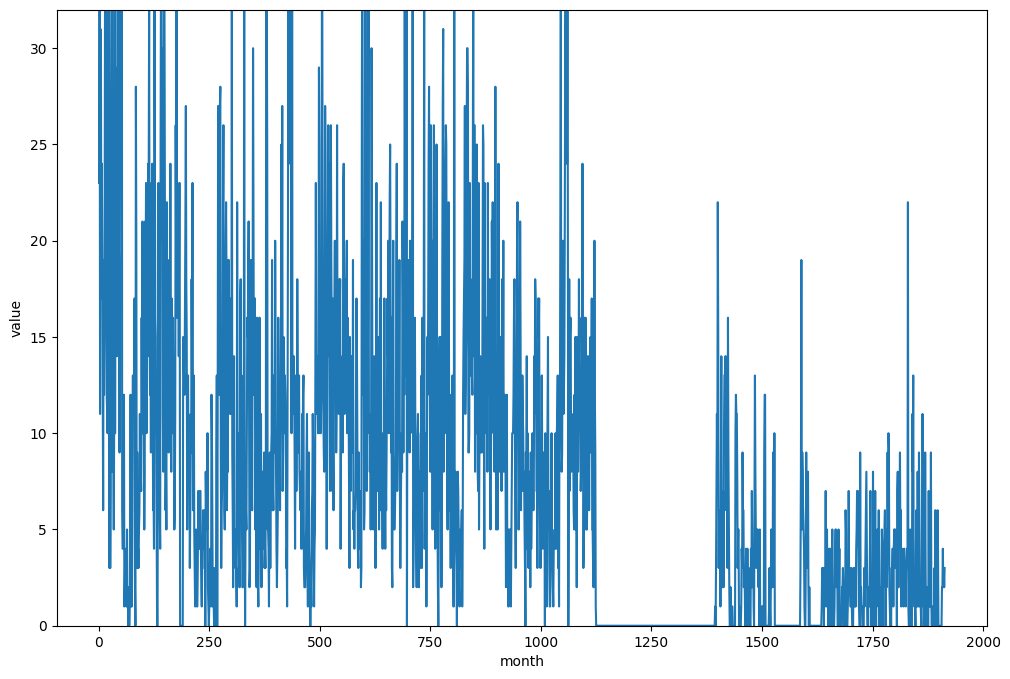

In [3]:
#Plotting data with time
plt.rcParams['figure.figsize'] = 12, 8
sns.lineplot(x='id', y='FOODS_1_032_CA_1_validation', data=df)
plt.xlabel('month')
plt.ylabel('value')
plt.ylim([0, 32])

(0.0, 80.0)

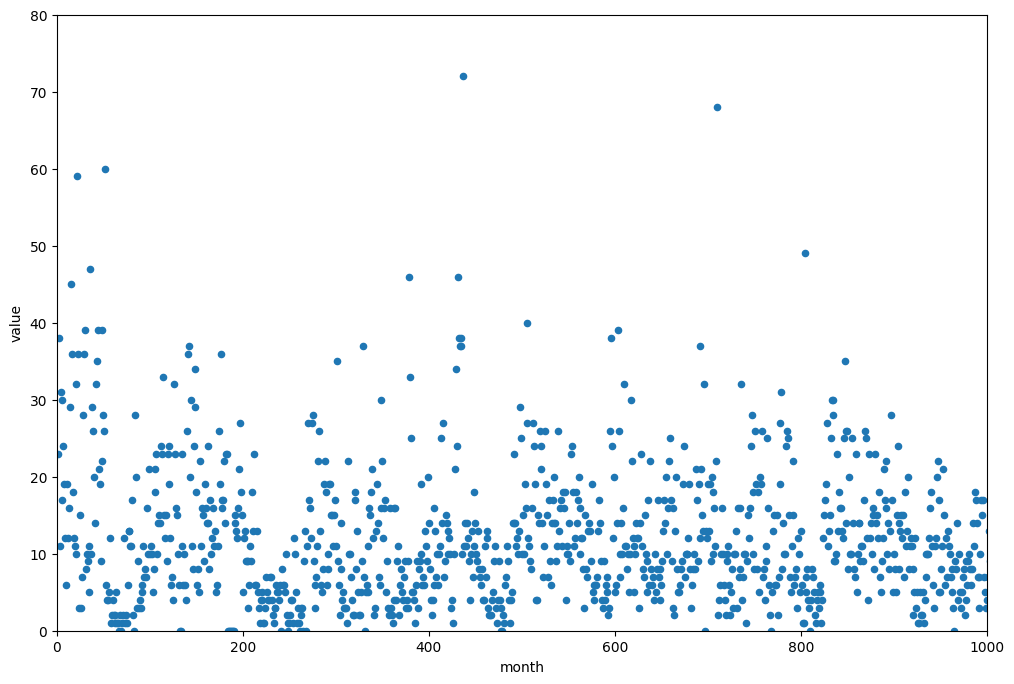

In [4]:
#Plotting data with time
plt.rcParams['figure.figsize'] = 12, 8
df.plot.scatter(x='id', y='FOODS_1_032_CA_1_validation')
plt.xlabel('month')
plt.ylabel('value')
plt.xlim([0, 1000])
plt.ylim([0, 80])

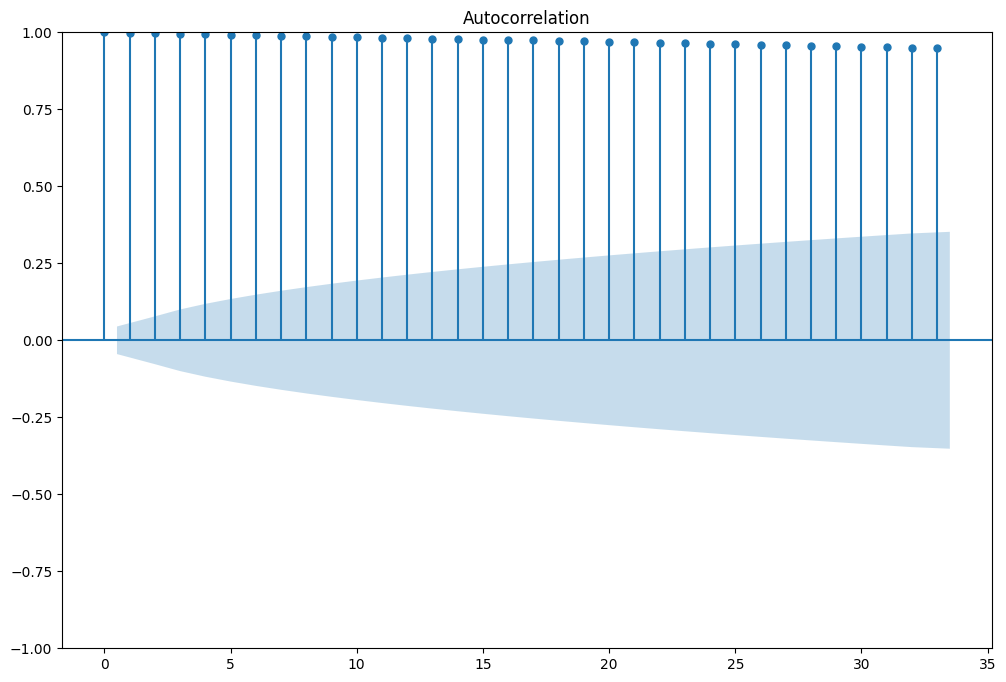

In [5]:
#Plotting auto-correlation
from statsmodels.graphics.tsaplots import plot_acf

acf = plot_acf(df['id'])

In [6]:
#Temporary
df = pd.read_csv('sales_train_edited2.csv')

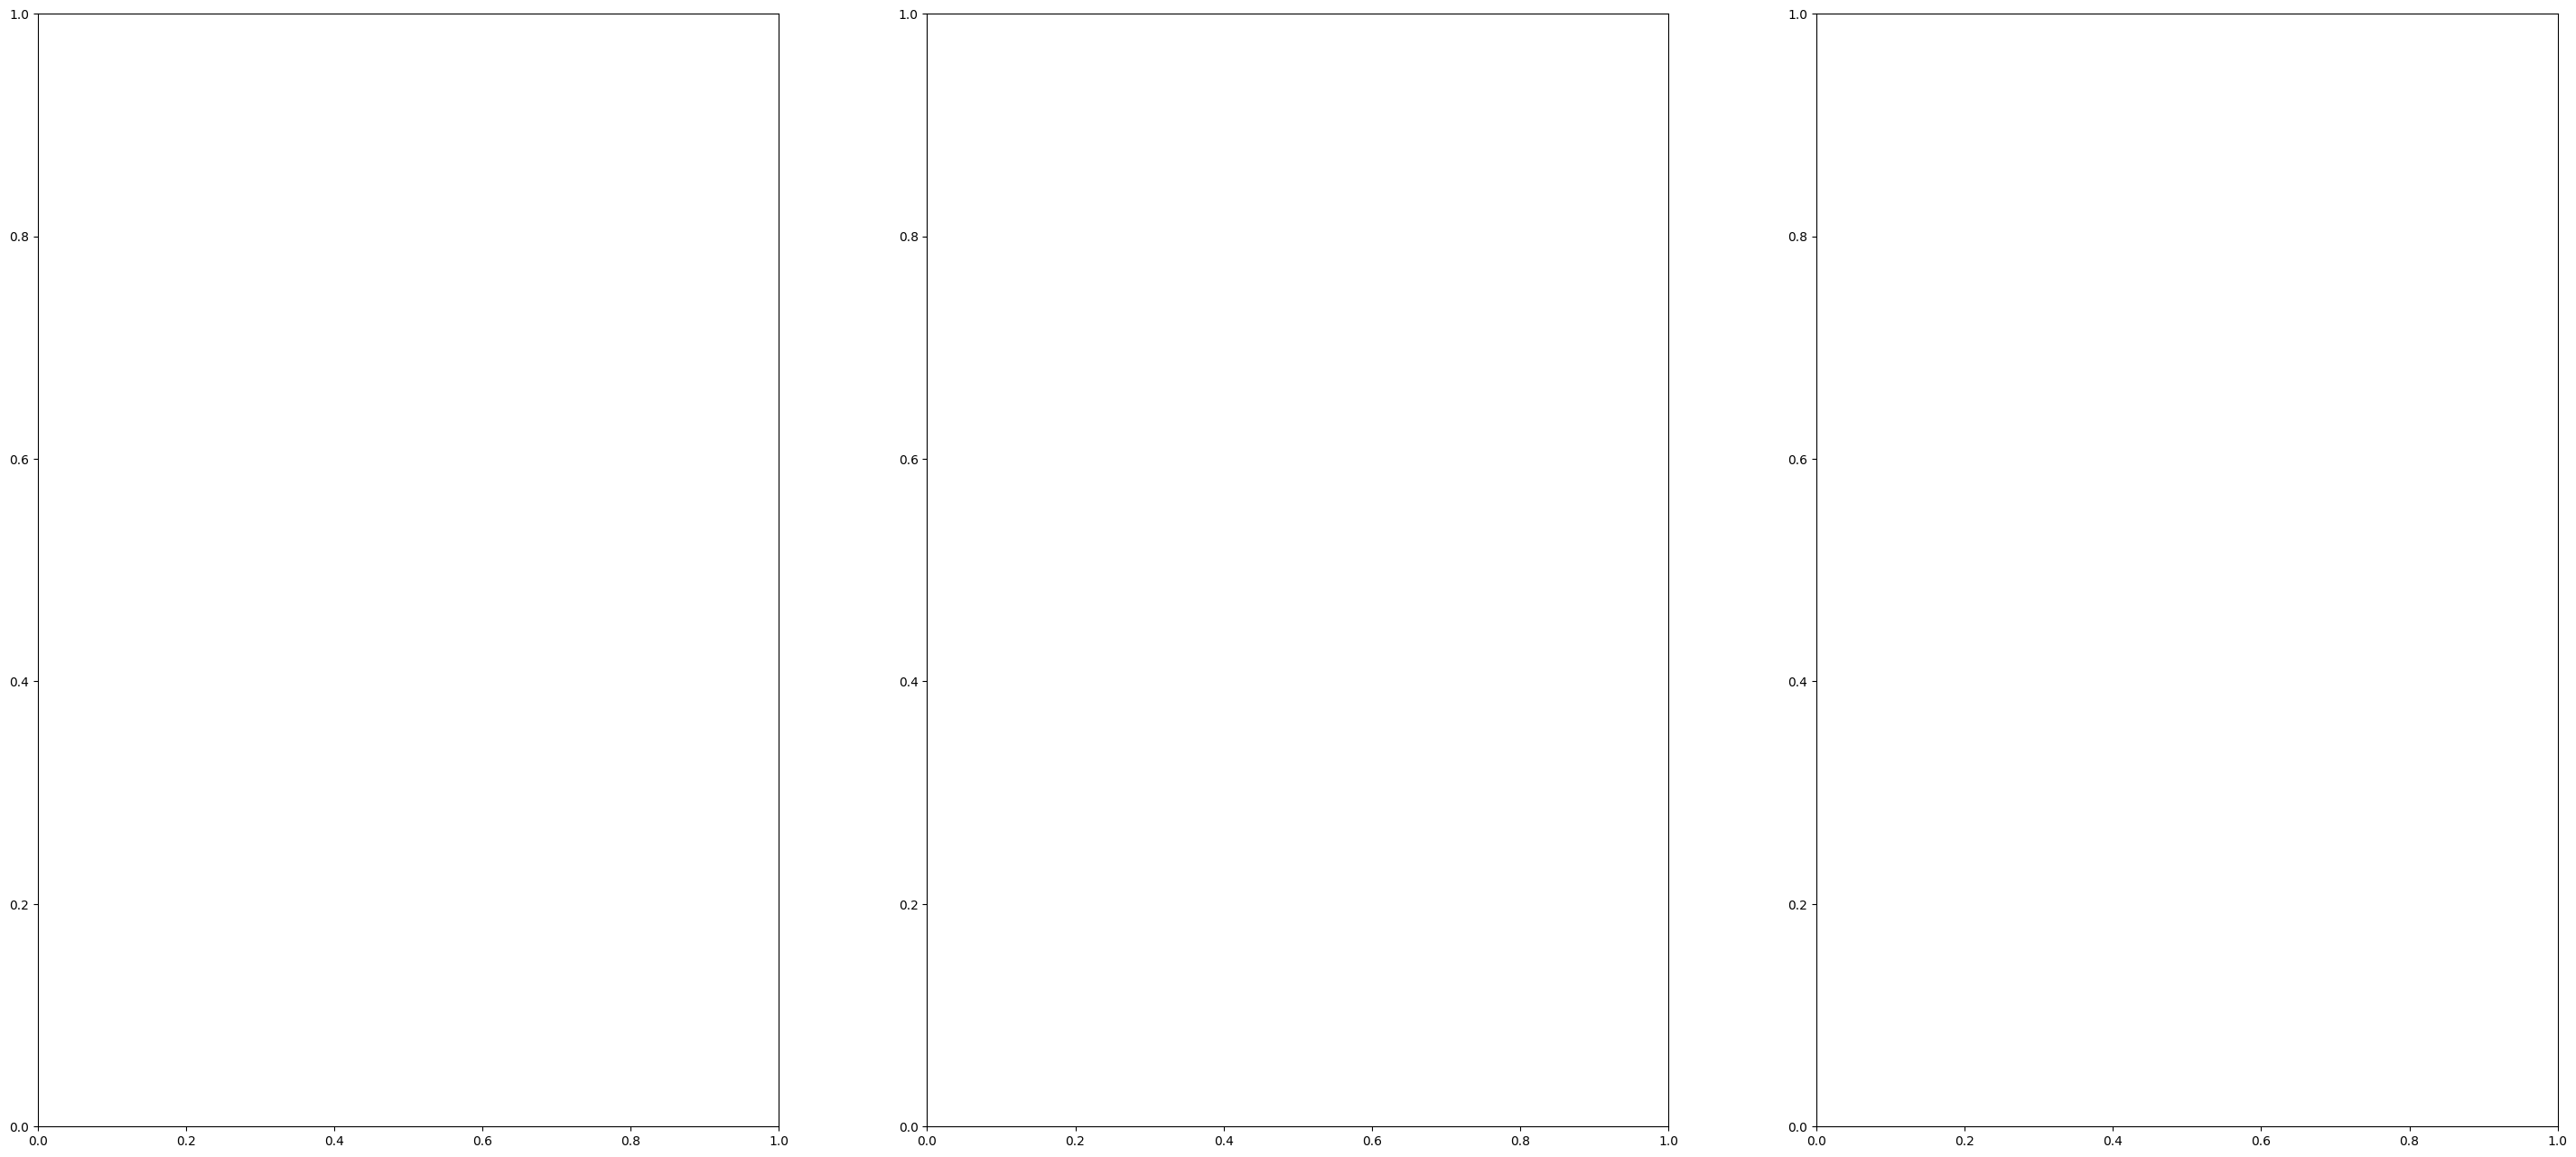

In [7]:
# Setting up the combined figure for the zoomed out results - Put in by Siddharth C.
fig, axs = plt.subplots(1, 3, figsize=(36, 16))

In [8]:
#converting dataframe to tensors
targets_df = pd.DataFrame(data=(df['id']))
targets_df.columns = ['targets']
torch_tensor = torch.tensor(targets_df['targets'].values)
train_x = torch_tensor


targets_df = pd.DataFrame(data=(df['FOODS_1_032_CA_1_validation']))
targets_df.columns = ['targets']
torch_tensor2 = torch.tensor(targets_df['targets'].values)
train_y = torch_tensor2.float()
# See why train_x and train_y are being made from the same column/row of the dataset. They should be different?

train_x = train_x.float()
train_y = train_y.float()

#normalize data
train_y = (train_y - train_y.mean()) / train_y.std()
train_x = (train_x - train_x.mean()) / train_x.std()

#split test set
test_x = train_x[900:1000]
train_x = train_x[0:900]
test_y = train_y[900:1000]
train_y = train_y[0:900]

In [9]:
print(len(test_x))
print(len(train_x))
print(len(test_y))
print(len(train_y))

100
900
100
900


In [10]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale = 2.0) * gpytorch.kernels.PeriodicKernel(lengthscale = 1.5) * gpytorch.kernels.MaternKernel(nu=2.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
print(likelihood)
print(model)
print(type(likelihood))
print(type(model))

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)
ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): ProductKernel(
      (kernels): ModuleList(
        (0): RBFKernel(
          (raw_lengthscale_constraint): Positive()
        )
        (1): PeriodicKernel(
          (raw_lengthscale_constraint): Positive()
          (raw_period_length_constraint): Positive()
        )
        (2): MaternKernel(
          (raw_lengthscale_constraint): Positive()
        )
      )
    )
    (raw_outputscale_constraint): Positive()
  )
)
<class 'gpytorch.likelihoods.gaussian_likelihood.GaussianLikelihood'>
<class '__main__.ExactGPModel'>


In [11]:
print(len(test_x))
print(len(train_x))
print(len(test_y))
print(len(train_y))

100
900
100
900


In [12]:
model.covar_module.base_kernel[1]

ProductKernel(
  (kernels): ModuleList(
    (0): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (1): PeriodicKernel(
      (raw_lengthscale_constraint): Positive()
      (raw_period_length_constraint): Positive()
    )
    (2): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
  )
)

In [13]:
#training
import os
smoke_test = ('CI' in os.environ)
training_iter = 1000 if smoke_test else 10 #number of iterations


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood.float(), model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    
    # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    #     i + 1, training_iter, loss.item(),
    #     model.covar_module.base_kernel.lengthscale.item(),
    #     model.likelihood.noise.item()
    # ))
    
    print('Iter %d/%d - Loss: %.3f' % (
         i + 1, training_iter, loss.item(),
    ))
    optimizer.step()

Iter 1/10 - Loss: 1.506
Iter 2/10 - Loss: 1.483
Iter 3/10 - Loss: 1.473
Iter 4/10 - Loss: 1.458
Iter 5/10 - Loss: 1.458
Iter 6/10 - Loss: 1.463
Iter 7/10 - Loss: 1.453
Iter 8/10 - Loss: 1.457
Iter 9/10 - Loss: 1.460
Iter 10/10 - Loss: 1.453


In [14]:
print(len(test_x))
print(len(train_x))
print(len(test_y))
print(len(train_y))

100
900
100
900


In [15]:
#Make predictions with the model
f_preds = model(train_x)
y_preds = likelihood(model(train_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

In [16]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

/opt/conda/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


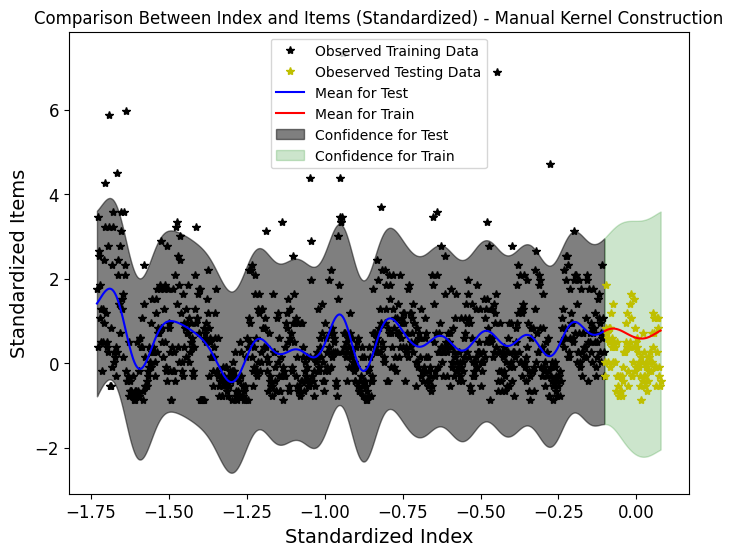

In [17]:
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Making predictions
    #test_x = torch.linspace(0, 1, 100)
    observed_pred = likelihood(model(train_x))
    observed_pred_test = likelihood(model(test_x))
    
    # Initializing the plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    lower_2, upper_2 = observed_pred_test.confidence_region()
    
    # Plotting training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), test_y.numpy(), 'y*')
    
    # Plotting predictive means as blue line
    ax.plot(train_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.plot(test_x.numpy(), observed_pred_test.mean.numpy(), 'r') # For test
    
    # Shade between the lower and upper confidence bounds
    ax.fill_between(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, color = 'black')
    ax.fill_between(test_x.numpy(), lower_2.numpy(), upper_2.numpy(), alpha = 0.2, color='green')

    

    ax.set_title('Comparison Between Index and Items (Standardized) - Manual Kernel Construction')
    

    ax.set_xlabel('Standardized Index', fontsize=14)
    ax.set_ylabel('Standardized Items', fontsize = 14)
    ax.tick_params(axis='both', labelsize=12)
    
    ax.legend(['Observed Training Data', 'Obeserved Testing Data', 'Mean for Test', 'Mean for Train', 'Confidence for Test', 'Confidence for Train'])
    plt.show()

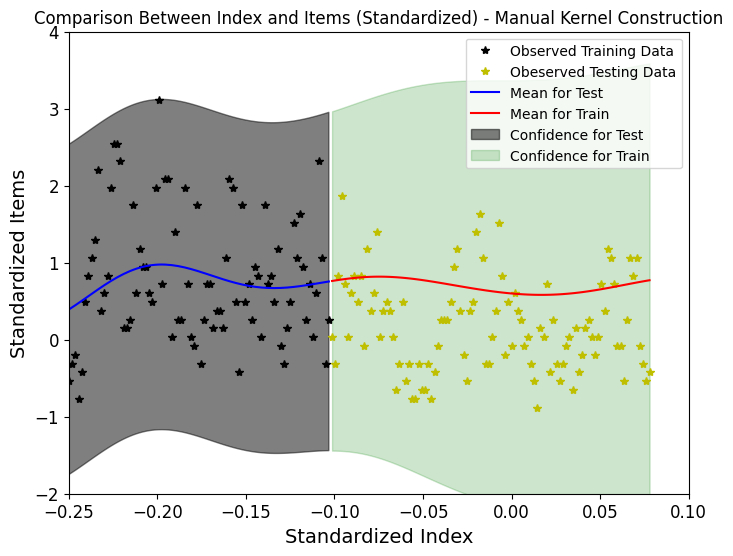

In [18]:
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Making predictions
    #test_x = torch.linspace(0, 1, 100)
    observed_pred = likelihood(model(train_x))
    observed_pred_test = likelihood(model(test_x))
    
    # Initializing the plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    lower_2, upper_2 = observed_pred_test.confidence_region()
    
    # Plotting training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), test_y.numpy(), 'y*')
    
    # Plotting predictive means as blue line
    ax.plot(train_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.plot(test_x.numpy(), observed_pred_test.mean.numpy(), 'r') # For test
    
    
    # Shade between the lower and upper confidence bounds
    ax.fill_between(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, color = 'black')
    ax.fill_between(test_x.numpy(), lower_2.numpy(), upper_2.numpy(), alpha = 0.2, color='green')

    
    ax.set_title('Comparison Between Index and Items (Standardized) - Manual Kernel Construction')
    

    ax.set_xlabel('Standardized Index', fontsize=14)
    ax.set_ylabel('Standardized Items', fontsize = 14)
    ax.tick_params(axis='both', labelsize=12)
    
    ax.set_ylim([-2, 4])
    ax.set_xlim([-0.25, 0.1])
    
    ax.legend(['Observed Training Data', 'Obeserved Testing Data', 'Mean for Test', 'Mean for Train', 'Confidence for Test', 'Confidence for Train'])
    plt.show()

In [19]:

# Subplot 1 (zoomed out) - Put in by Siddharth C.
axs[0].plot(train_x.numpy(), train_y.numpy(), 'k*')
axs[0].plot(test_x.numpy(), test_y.numpy(), 'y*')
axs[0].plot(test_x.numpy(), observed_pred_test.mean.numpy(), 'r')
axs[0].plot(train_x.numpy(), observed_pred.mean.numpy(), 'b')
lower, upper = observed_pred.confidence_region()
lower_2, upper_2 = observed_pred_test.confidence_region()
axs[0].fill_between(test_x.numpy(), lower_2.numpy(), upper_2.numpy(), alpha=0.2, color='green')
axs[0].fill_between(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, color='black')
axs[0].set_ylim([-2, 4.5])
axs[0].set_xlim([-1.75, 0.1])
# axs[0].set_xlim([-1.75, 0.35])
axs[0].set_xlabel('Standardized Index', fontsize=40)
axs[0].set_ylabel('Standardized Items', fontsize=40)
axs[0].set_title('Manual Forecasting', fontsize=42)


Text(0.5, 1.0, 'Manual Forecasting')

In [20]:
print(len(upper_2))

100


In [21]:
#Evaluation
!pip install git+https://github.com/jpchen/autoforecasting.git
from sts.data import get_mvn_stats
from torch.distributions import ComposeTransform, ExpTransform

  Cloning https://github.com/jpchen/autoforecasting.git to /tmp/pip-req-build-lv4xxy8z
  Running command git clone --filter=blob:none --quiet https://github.com/jpchen/autoforecasting.git /tmp/pip-req-build-lv4xxy8z
  Resolved https://github.com/jpchen/autoforecasting.git to commit f07246ce45673579f364939f6d1469c33b202a6b
  Preparing metadata (setup.py) ... done
  Created wheel for timeseries: filename=timeseries-0.0.0-py3-none-any.whl size=42057 sha256=0d1ef67606072e4c6817f3f579f5215e0fbbfe959e875cbe1381a1db68d7c3b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-zittrq2d/wheels/6b/16/5a/3645e1c96e982a34fcd4a5ff36ce5e504cdcf7f8e4cf8e97fa
Successfully built timeseries


In [22]:
#Mean Absolute Error (MAE)
pred_train = likelihood(model(train_x))
pred_test = likelihood(model(test_x))

from sts.metrics import MAE

MAE_train = MAE(train_y, pred_train.mean).item()
MAE_test = MAE(test_y, pred_test.mean).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

Mean absolute error for training set is: 0.720
Mean absolute error for test set is: 0.675


In [23]:
#Continuous ranked probability score (CRPS)
!wget https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
from metrics import crps_gaussian
all_data = torch.cat([train_x, test_x], dim=0)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_all = likelihood(model(all_data))
    
train_var = pred_all.variance[:len(train_x)] 
test_var = pred_all.variance[:len(test_x)] 

# To work for the crps test.
pred_train = pred_train.mean.detach().numpy()
pred_test = pred_test.mean.detach().numpy()

crps_train = crps_gaussian(train_y, pred_train.mean(), train_var.sqrt())
crps_test = crps_gaussian(test_y, pred_test.mean(), test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

--2024-01-11 03:45:07--  https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8399 (8.2K) [text/plain]
Saving to: ‘metrics.py.194’

metrics.py.194      100%[===================>]   8.20K  --.-KB/s    in 0s      

2024-01-11 03:45:07 (40.2 MB/s) - ‘metrics.py.194’ saved [8399/8399]

Continuous ranked probability score for training set is: 0.578
Continuous ranked probability score for test set is: 0.466


In [24]:
#Log-likelihood (LL)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_train = likelihood(model(train_y))
    pred_test = likelihood(model(test_y))

y_preds_train_mean = pred_train.mean
y_preds_test_mean = pred_test.mean

from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(y_preds_train_mean, train_y, train_var).item()
ll_test = log_likelihood_error(y_preds_test_mean, test_y, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')

Log-likelihood for training set is: -1.452
Log-likelihood for test set is: -1.219


/opt/conda/lib/python3.7/site-packages/sts/metrics.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  -0.5 * torch.log(torch.tensor(2 * math.pi * var)).mean()


In [25]:
scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_measure = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_measure

,MAE,CPRS,LL
0,0.719572,0.578383,-1.451827
1,0.674726,0.466101,-1.219334


In [26]:
#Autoforecasting
!pip install git+https://github.com/jpchen/autoforecasting.git

from sts.gp.model import ExactGPAdditiveModel 
from gpytorch.kernels import LinearKernel, RBFKernel

  Cloning https://github.com/jpchen/autoforecasting.git to /tmp/pip-req-build-4rk71yzx
  Running command git clone --filter=blob:none --quiet https://github.com/jpchen/autoforecasting.git /tmp/pip-req-build-4rk71yzx
  Resolved https://github.com/jpchen/autoforecasting.git to commit f07246ce45673579f364939f6d1469c33b202a6b
  Preparing metadata (setup.py) ... done


In [27]:
from sts.data import df_to_tensor
df_float = df.astype('float32') # All issues with data fixed here, but the categories are still present (not a tensor).
df1 = df_to_tensor(df_float, normalize_cols=True) # Now a tensor

In [28]:
from sts.data import DataTensor
# For training data
train_x = df1[0:900, ['id']]
train_y = df1[0:900, ['FOODS_1_032_CA_1_validation']]

test_x = df1[900:1000, ['id']]
test_y = df1[900:1000, ['FOODS_1_032_CA_1_validation']]

In [29]:
train_x.tensor = train_x.tensor.squeeze(-1)
train_y.tensor = train_y.tensor.squeeze(-1)
test_x.tensor = test_x.tensor.squeeze(-1)
test_y.tensor = test_y.tensor.squeeze(-1)

In [30]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = ExactGPAdditiveModel(train_x, train_y, likelihood) # This model requires two DataTensors, unlike the other model. 
# model.cov.add_seasonality(
#             time_axis="index", period_length=365.25, fix_period=True
#         )

model.cov.add_trend(
    time_axis="id", kernel_cls=LinearKernel, name="LinearTrend"
)
model.cov.add_trend(
    time_axis="id",
    kernel_cls=RBFKernel,
    lengthscale=0.2,
    fix_lengthscale=True,
    name="RBFTrend",
)
model.cov.add_spectral_mixture(
    time_axis="id",
    num_mixtures=2,
    train_x=train_x.tensor,
    train_y=train_y.tensor,
    name="SM1",
)
model.cov.add_spectral_mixture(
    time_axis="id",
    num_mixtures=2,
    train_x=train_x.tensor,
    train_y=train_y.tensor,
    name="SM2",
)
model.cov.add_seasonality(
    time_axis="id", 
    period_length=0.2, 
    fix_period=True, 
    name="Seasonality"
)

In [31]:
#Training loop
learning_rate = 0.01
num_epochs = 1000 # Adjust as needed. Keep it lower until finalized.
# 1000 is a reasonable amount, as this model is quite slow at training.

trainer = model.train_init(torch.optim.Adam(model.trainable_params, lr=learning_rate))

def train():
    for epoch in range(num_epochs):
        loss = trainer(train_x, train_y)
        print(f'epoch {epoch+1}/{num_epochs}, loss {loss}')

%time train()

epoch 1/1000, loss 1.641927719116211
epoch 2/1000, loss 1.6510953903198242
epoch 3/1000, loss 1.651487946510315
epoch 4/1000, loss 1.6330245733261108
epoch 5/1000, loss 1.6503926515579224
epoch 6/1000, loss 1.6366368532180786
epoch 7/1000, loss 1.6352282762527466
epoch 8/1000, loss 1.6392050981521606
epoch 9/1000, loss 1.631993293762207
epoch 10/1000, loss 1.6369532346725464
epoch 11/1000, loss 1.6429760456085205
epoch 12/1000, loss 1.6350529193878174
epoch 13/1000, loss 1.6363979578018188
epoch 14/1000, loss 1.6441386938095093
epoch 15/1000, loss 1.6350510120391846
epoch 16/1000, loss 1.6440353393554688
epoch 17/1000, loss 1.641632318496704
epoch 18/1000, loss 1.6246514320373535
epoch 19/1000, loss 1.6393234729766846
epoch 20/1000, loss 1.6234039068222046
epoch 21/1000, loss 1.6296964883804321
epoch 22/1000, loss 1.63831627368927
epoch 23/1000, loss 1.63380765914917
epoch 24/1000, loss 1.6270486116409302
epoch 25/1000, loss 1.6266874074935913
epoch 26/1000, loss 1.6227970123291016
epo

/opt/conda/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


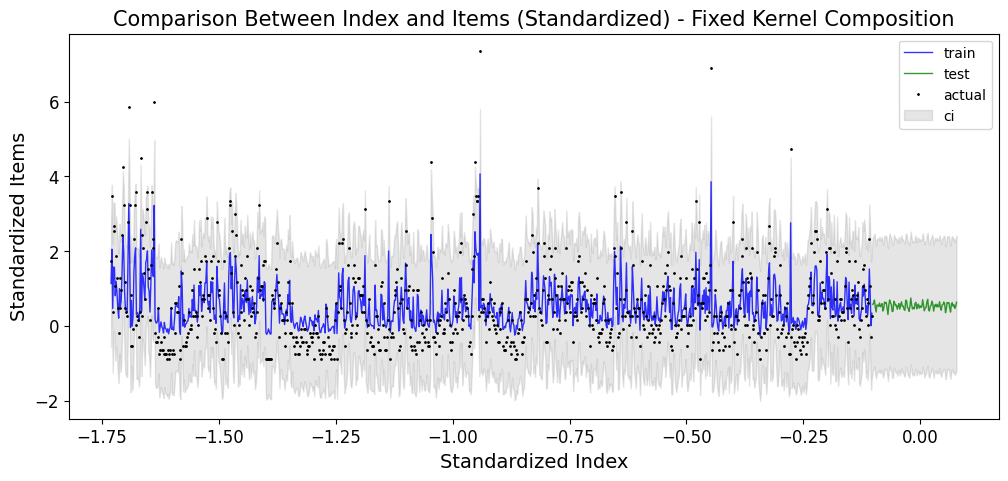

In [32]:
#Predictions
#Calculate GP predictions and statistics
train_mean, train_var, train_ci = get_mvn_stats(model.predict(train_x))
test_mean, test_var, test_ci = get_mvn_stats(model.predict(test_x))

# Create a figure and axis for the plot
f, ax = plt.subplots(1, 1, figsize=(12, 5))

# Plot the training and test mean values
ax.plot(train_x.tensor, train_mean, alpha=0.8, color='blue', linewidth=1, label='train') 
ax.plot(test_x.tensor, test_mean, alpha=0.8, color='green', linewidth=1, label='test') # This one is not graphing, only the above one.

#df_4_float['index'][1853:]
# Plot the actual data points
ax.plot(train_x.tensor, train_y.tensor, 'o', markersize=1, color='black', label='actual')

# Fill the area between confidence intervals
ci_values = torch.cat([train_ci[0], test_ci[0]]), torch.cat([train_ci[1], test_ci[1]])
x = torch.cat([train_x, test_x])
ax.fill_between(x, ci_values[0], ci_values[1], alpha=0.2, label='ci', color='gray')

# Add labels, title, and legend
ax.set_xlabel('Standardized Index', fontsize=14)
ax.set_ylabel('Standardized Items', fontsize = 14)
ax.tick_params(axis='both', labelsize=12)
ax.set_title('Comparison Between Index and Items (Standardized) - Fixed Kernel Composition', fontsize=15)
ax.legend()
# ax.legend(['1', '2', '3'])


# Show the plot
plt.show()

# Fix this issue: ValueError: 'x' is not 1-dimensional (need to re-run the x-train data twice to get the graph)
# All blocks below this one works. Please see block 26 for understanding an issue with getting the graph for this block (block 32).

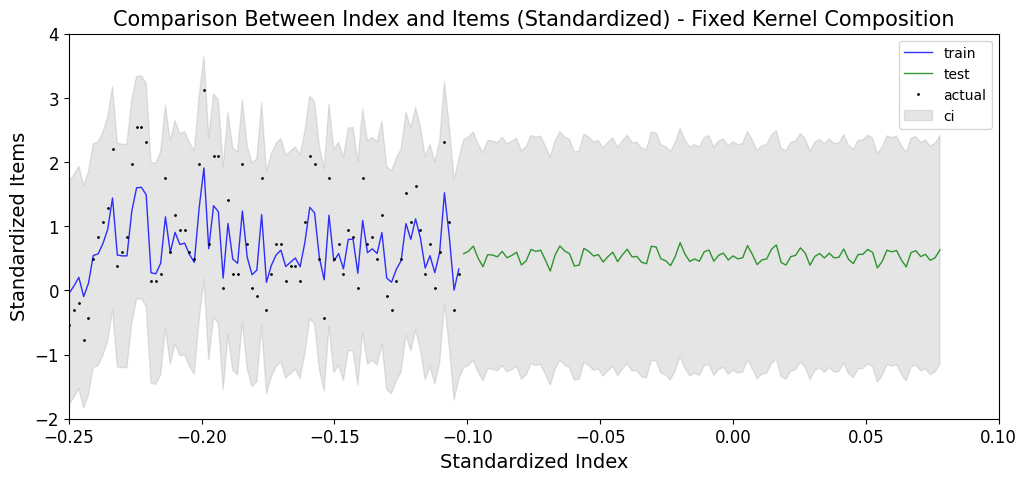

In [33]:
#Predictions
#Calculate GP predictions and statistics
train_mean, train_var, train_ci = get_mvn_stats(model.predict(train_x))
test_mean, test_var, test_ci = get_mvn_stats(model.predict(test_x))

# Create a figure and axis for the plot
f, ax = plt.subplots(1, 1, figsize=(12, 5))

# Plot the training and test mean values
ax.plot(train_x.tensor, train_mean, alpha=0.8, color='blue', linewidth=1, label='train') 
ax.plot(test_x.tensor, test_mean, alpha=0.8, color='green', linewidth=1, label='test') # This one is not graphing, only the above one.

#df_4_float['index'][1853:]
# Plot the actual data points
ax.plot(train_x.tensor, train_y.tensor, 'o', markersize=1, color='black', label='actual')

# Fill the area between confidence intervals
ci_values = torch.cat([train_ci[0], test_ci[0]]), torch.cat([train_ci[1], test_ci[1]])
x = torch.cat([train_x, test_x])
ax.fill_between(x, ci_values[0], ci_values[1], alpha=0.2, label='ci', color='gray')

# Add labels, title, and legend
ax.set_xlabel('Standardized Index', fontsize=14)
ax.set_ylabel('Standardized Items', fontsize = 14)
ax.tick_params(axis='both', labelsize=12)
ax.set_title('Comparison Between Index and Items (Standardized) - Fixed Kernel Composition', fontsize=15)
ax.legend()
# ax.legend(['1', '2', '3'])

ax.set_ylim([-2, 4])
ax.set_xlim([-0.25, 0.1])

# Show the plot
plt.show()


# Fix this issue: ValueError: 'x' is not 1-dimensional (need to re-run the x-train data twice to get the graph)
# All blocks below this one works. Please see block 26 for understanding an issue with getting the graph for this block (block 32).

In [34]:

# Subplot 2 (zoomed out) - Put in by Siddharth C.
axs[1].plot(train_x.tensor, train_mean, alpha=0.8, color='blue', linewidth=1) 
axs[1].plot(test_x.tensor, test_mean, alpha=0.8, color='red', linewidth=1)
axs[1].plot(train_x.tensor, train_y.tensor, 'k*')
axs[1].plot(test_x.tensor, test_y.tensor, 'y*')
ci_values = torch.cat([train_ci[0], test_ci[0]]), torch.cat([train_ci[1], test_ci[1]])
x = torch.cat([train_x, test_x])
axs[1].fill_between(train_x, train_ci[0], train_ci[1], alpha=0.2, color='black')
axs[1].fill_between(test_x, test_ci[0], test_ci[1], alpha=0.2, color='green')
axs[1].set_ylim([-2, 4.5])
axs[1].set_xlim([-1.75, 0.1])
#axs[1].set_xlim([-1.75, 0.35])
axs[1].set_yticklabels([])
axs[1].set_xlabel('Standardized Index', fontsize=40)
axs[1].set_title('Fixed Kernel Composition', fontsize=42)


Text(0.5, 1.0, 'Fixed Kernel Composition')

In [35]:
#Evaluation
train_mean, train_var, train_ci = get_mvn_stats(model.predict(train_x))
test_mean, test_var, test_ci = get_mvn_stats(model.predict(test_x))

# Needed to make sure the data works with the below test code that I had already modified to work with the manual kernel-fitting part.
train_x = train_x.tensor
train_y = train_y.tensor
test_x = test_x.tensor
test_y = test_y.tensor
pred_train = train_mean
pred_test = test_mean

In [36]:
from sts.metrics import MAE
# train_mean, train_var, train_ci = get_mvn_stats(model.predict(x_train))
# test_mean, test_var, test_ci = get_mvn_stats(model.predict(x_test))
# For the above two lines, the error lies in the .predict() function, which does not seem to exist anymore. 

MAE_train = MAE(train_y, pred_train).item()
MAE_test = MAE(test_y, pred_test).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

Mean absolute error for training set is: 0.399
Mean absolute error for test set is: 0.595


In [37]:
!wget https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
from metrics import crps_gaussian
crps_train = crps_gaussian(train_y, pred_train, train_var.sqrt())
crps_test = crps_gaussian(test_y, pred_test, test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

--2024-01-11 03:46:46--  https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8399 (8.2K) [text/plain]
Saving to: ‘metrics.py.195’

metrics.py.195      100%[===================>]   8.20K  --.-KB/s    in 0s      

2024-01-11 03:46:46 (51.4 MB/s) - ‘metrics.py.195’ saved [8399/8399]

Continuous ranked probability score for training set is: 0.343
Continuous ranked probability score for test set is: 0.423


In [38]:
from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(train_mean, pred_train, train_var).item()
ll_test = log_likelihood_error(test_mean, pred_test, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')

Log-likelihood for training set is: -0.976
Log-likelihood for test set is: -0.998


/opt/conda/lib/python3.7/site-packages/sts/metrics.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  -0.5 * torch.log(torch.tensor(2 * math.pi * var)).mean()


In [39]:
scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_measure = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_measure

,MAE,CPRS,LL
0,0.398816,0.343319,-0.975889
1,0.595399,0.423422,-0.997795


In [40]:
#Changepoint
from sts.changepoints import BinSegChangepoint
binseg = BinSegChangepoint()
changepoints = binseg.get_changepoints(train_x, train_y) #x_train and y_train should be tensors for this line.
# create kernel
from sts.gp.cov import ChangePoint
from sts.gp.cov import Trend

# Reformatting training and testing data.
train_data = df1[:900]
test_data = df1[900:]

#RBF Kernels
rbf_kernel1 = Trend(train_data, "id", kernel=RBFKernel, lengthscale=1.0, fix_lengthscale=True)
rbf_kernel2 = Trend(train_data, "id", kernel=RBFKernel, lengthscale=1.0, fix_lengthscale=True)
rbf_kernel3 = Trend(train_data, "id", kernel=RBFKernel, lengthscale=1.0, fix_lengthscale=True)

# Creating a list of the RBF kernels to use for the changepoint
rbf_kernels = [rbf_kernel1, rbf_kernel2, rbf_kernel3]

# ChangePoint Kernel
cp_kernel = ChangePoint(
                    train_data,
                    "id",
                    rbf_kernels,
                    changepoint_location=changepoints,
                    changepoint_steep=1.0,
                    fix_changepoint_location=True,
                    fix_changepoint_steep=True,
                    name="Changepoint - RBF",
                )

model.cov.append(cp_kernel) # Adding to your model.

In [41]:
print(model)

ExactGPAdditiveModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean): Mean(
    (means): ModuleList(
      (0): ConstantMean()
    )
  )
  (cov): Covariance(
    (kernel): AdditiveKernel(
      (kernels): ModuleList(
        (0): ScaleKernel(
          (base_kernel): LinearKernel(
            (raw_variance_constraint): Positive()
          )
          (raw_outputscale_constraint): Positive()
        )
        (1): ScaleKernel(
          (base_kernel): RBFKernel(
            (raw_lengthscale_constraint): Positive()
            (distance_module): Distance()
          )
          (raw_outputscale_constraint): Positive()
        )
        (2): SpectralMixtureKernel(
          (raw_mixture_scales_constraint): Positive()
          (raw_mixture_means_constraint): Positive()
          (raw_mixture_weights_constraint): Positive()
        )
        (3): SpectralMixtureKernel(
          (raw_mixtur

In [42]:
import os
smoke_test = ("CI" in os.environ)
training_iter = 1000

# Finding the optimal parameters for the model
model = ExactGPModel(train_x, train_y, likelihood)
model.train()
likelihood.train()

# Using the ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1) # Change the learning rate as needed. Lower should be better.

# Finding the marginal log likelihood, or the "loss" for GPs
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def training():
    for i in range(training_iter):
      optimizer.zero_grad()
      output = model(train_x)
      loss = -mll(output, train_y)
      loss.backward()
      print("Iter %d/%d - Loss: %.3f" % (i + 1, training_iter, loss.item()))
      optimizer.step()
        
%time training()

Iter 1/1000 - Loss: 1.558
Iter 2/1000 - Loss: 1.539
Iter 3/1000 - Loss: 1.506
Iter 4/1000 - Loss: 1.494
Iter 5/1000 - Loss: 1.478
Iter 6/1000 - Loss: 1.468
Iter 7/1000 - Loss: 1.447
Iter 8/1000 - Loss: 1.444
Iter 9/1000 - Loss: 1.443
Iter 10/1000 - Loss: 1.440
Iter 11/1000 - Loss: 1.442
Iter 12/1000 - Loss: 1.454
Iter 13/1000 - Loss: 1.441
Iter 14/1000 - Loss: 1.446
Iter 15/1000 - Loss: 1.441
Iter 16/1000 - Loss: 1.442
Iter 17/1000 - Loss: 1.449
Iter 18/1000 - Loss: 1.444
Iter 19/1000 - Loss: 1.443
Iter 20/1000 - Loss: 1.437
Iter 21/1000 - Loss: 1.443
Iter 22/1000 - Loss: 1.439
Iter 23/1000 - Loss: 1.443
Iter 24/1000 - Loss: 1.438
Iter 25/1000 - Loss: 1.429
Iter 26/1000 - Loss: 1.430
Iter 27/1000 - Loss: 1.428
Iter 28/1000 - Loss: 1.422
Iter 29/1000 - Loss: 1.420
Iter 30/1000 - Loss: 1.424
Iter 31/1000 - Loss: 1.419
Iter 32/1000 - Loss: 1.420
Iter 33/1000 - Loss: 1.415
Iter 34/1000 - Loss: 1.416
Iter 35/1000 - Loss: 1.419
Iter 36/1000 - Loss: 1.413
Iter 37/1000 - Loss: 1.414
Iter 38/10

/opt/conda/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


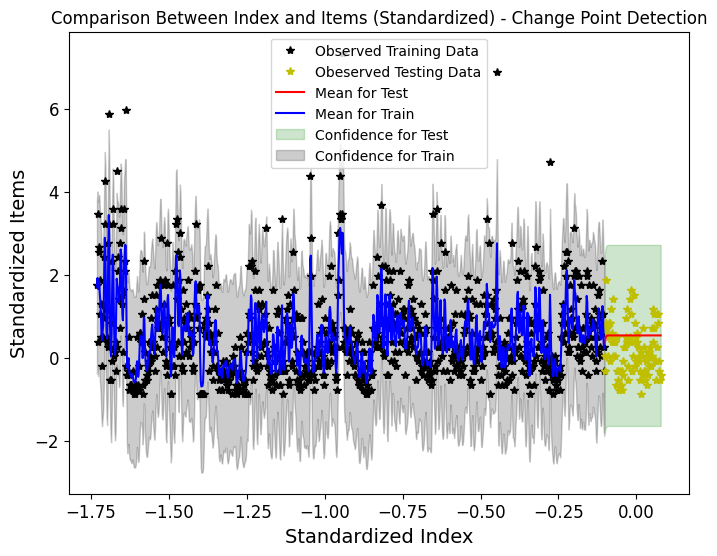

In [43]:
# Get into evaluation mode, or the predictive posterior mode
# Add the training and test metrics. Ex. MSE and MAE and CRPS. Test each individually.
# These tests have been incorporated as functions into the GPModel Class

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Making predictions
    
    pred_train = likelihood(model(train_x))
    pred_test = likelihood(model(test_x))
    
    # Setting up the train_mean and test_mean so they can be used for some of the later tests.
    train_mean = pred_train.mean.numpy()
    test_mean = pred_test.mean.numpy()

    
    # Concatenate x_train and x_test together to get all data points for aid in calculating the variances.
    all_data = torch.cat([train_x, test_x], dim=0)

    # Get predictions and variances for all data points
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_all = likelihood(model(all_data))

    # Extract the variances for test and train data
    train_var = pred_all.variance[:len(train_x)]  # Variances for training data
    test_var = pred_all.variance[len(train_x):]   # Variances for test data


    # Initializing the plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Getting the upper and lower confidence bounds
    lower, upper = pred_train.confidence_region()
    lower_2, upper_2 = pred_test.confidence_region()
    
    # Plotting training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), test_y.numpy(), 'y*')

    
    # Plotting predictive means as blue line
    ax.plot(test_x.numpy(), pred_test.mean.numpy(), 'r') # For test
    ax.plot(train_x.numpy(), pred_train.mean.numpy(), 'b') # For train
    
    import matplotlib.patches as patches

    # Shading the region between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower_2.numpy(), upper_2.numpy(), alpha = 0.2, color='green')
    ax.fill_between(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, color='black')

    # Adding labels for the x and y axes
    ax.set_xlabel('Standardized Index', fontsize=14)
    ax.set_ylabel('Standardized Items', fontsize = 14)
    ax.tick_params(axis='both', labelsize=12)
    
    # plt.fit()
    ax.legend(['Observed Training Data', 'Obeserved Testing Data', 'Mean for Test', 'Mean for Train', 'Confidence for Test', 'Confidence for Train', 'Confidence for Test'])
    ax.set_title('Comparison Between Index and Items (Standardized) - Change Point Detection')
    plt.show()

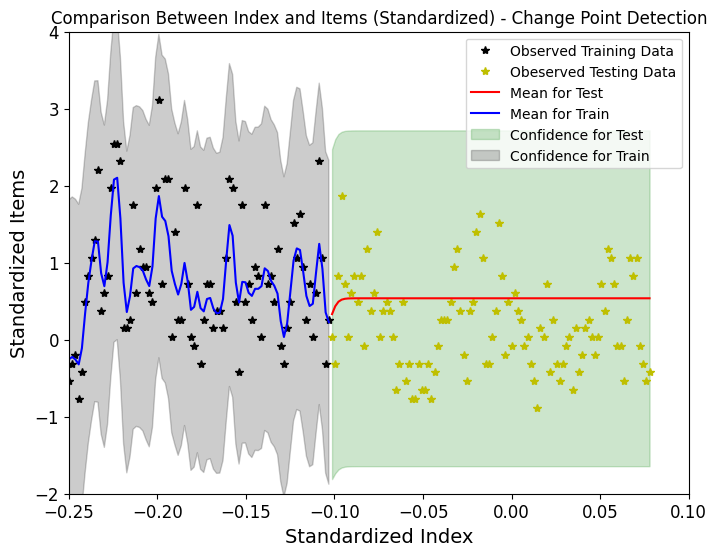

In [44]:
# Get into evaluation mode, or the predictive posterior mode
# Add the training and test metrics. Ex. MSE and MAE and CRPS. Test each individually.
# These tests have been incorporated as functions into the GPModel Class

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Making predictions
    
    pred_train = likelihood(model(train_x))
    pred_test = likelihood(model(test_x))
    
    # Setting up the train_mean and test_mean so they can be used for some of the later tests.
    train_mean = pred_train.mean.numpy()
    test_mean = pred_test.mean.numpy()

    
    # Concatenate x_train and x_test together to get all data points for aid in calculating the variances.
    all_data = torch.cat([train_x, test_x], dim=0)

    # Get predictions and variances for all data points
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_all = likelihood(model(all_data))

    # Extract the variances for test and train data
    train_var = pred_all.variance[:len(train_x)]  # Variances for training data
    test_var = pred_all.variance[len(train_x):]   # Variances for test data


    # Initializing the plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Getting the upper and lower confidence bounds
    lower, upper = pred_train.confidence_region()
    lower_2, upper_2 = pred_test.confidence_region()
    
    # Plotting training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), test_y.numpy(), 'y*')

    
    # Plotting predictive means as blue line
    ax.plot(test_x.numpy(), pred_test.mean.numpy(), 'r') # For test
    ax.plot(train_x.numpy(), pred_train.mean.numpy(), 'b') # For train
    
    import matplotlib.patches as patches

    # Shading the region between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower_2.numpy(), upper_2.numpy(), alpha = 0.2, color='green')
    ax.fill_between(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, color='black')

    ax.set_ylim([-2, 4]) 
    ax.set_xlim([-0.25, 0.1])
    
    # Adding labels for the x and y axes
    ax.set_xlabel('Standardized Index', fontsize=14)
    ax.set_ylabel('Standardized Items', fontsize = 14)
    ax.tick_params(axis='both', labelsize=12)
    
    # plt.fit()
    ax.legend(['Observed Training Data', 'Obeserved Testing Data', 'Mean for Test', 'Mean for Train', 'Confidence for Test', 'Confidence for Train', 'Confidence for Test'])
    ax.set_title('Comparison Between Index and Items (Standardized) - Change Point Detection')
    plt.show()

In [45]:

# Subplot 3 (zoomed out) - Put in by Siddharth C.
axs[2].plot(train_x.numpy(), train_y.numpy(), 'k*')
axs[2].plot(test_x.numpy(), test_y.numpy(), 'y*')
axs[2].plot(test_x.numpy(), pred_test.mean.numpy(), 'r')
axs[2].plot(train_x.numpy(), pred_train.mean.numpy(), 'b')
lower, upper = pred_train.confidence_region()
lower_2, upper_2 = pred_test.confidence_region()
axs[2].fill_between(test_x.numpy(), lower_2.numpy(), upper_2.numpy(), alpha=0.2, color='green')
axs[2].fill_between(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, color='black')
axs[2].set_ylim([-2, 4.5])
axs[2].set_xlim([-1.75, 0.1])
#axs[2].set_xlim([-1.75, 0.35])
axs[2].set_xlabel('Standardized Index', fontsize=40)
axs[2].set_yticklabels([])
axs[2].set_title('FKC + Changepoint Detection', fontsize=42)
# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.tight_layout(pad=2.0)


<Figure size 1200x800 with 0 Axes>

In [46]:
#Evaluation
from sts.metrics import MAE
MAE_train = MAE(train_y, pred_train.mean).item()
MAE_test = MAE(test_y, pred_test.mean).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

Mean absolute error for training set is: 0.398
Mean absolute error for test set is: 0.591


In [47]:
!wget https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
from metrics import crps_gaussian
pred_train, pred_test = pred_train.mean.numpy(), pred_test.mean.numpy() # To work for the crps test.
crps_train = crps_gaussian(train_y, pred_train, train_var.sqrt())
crps_test = crps_gaussian(test_y, pred_test, test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

--2024-01-11 03:47:59--  https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8399 (8.2K) [text/plain]
Saving to: ‘metrics.py.196’

metrics.py.196      100%[===================>]   8.20K  --.-KB/s    in 0s      

2024-01-11 03:47:59 (41.5 MB/s) - ‘metrics.py.196’ saved [8399/8399]

Continuous ranked probability score for training set is: 0.347
Continuous ranked probability score for test set is: 0.421


In [48]:
from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(train_mean, pred_train, train_var).item()
ll_test = log_likelihood_error(test_mean, pred_test, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')

Log-likelihood for training set is: -0.952
Log-likelihood for test set is: -1.005


/opt/conda/lib/python3.7/site-packages/sts/metrics.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  -0.5 * torch.log(torch.tensor(2 * math.pi * var)).mean()


In [49]:
scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_measure = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_measure

,MAE,CPRS,LL
0,0.397870,0.347020,-0.951714
1,0.590701,0.421265,-1.005113


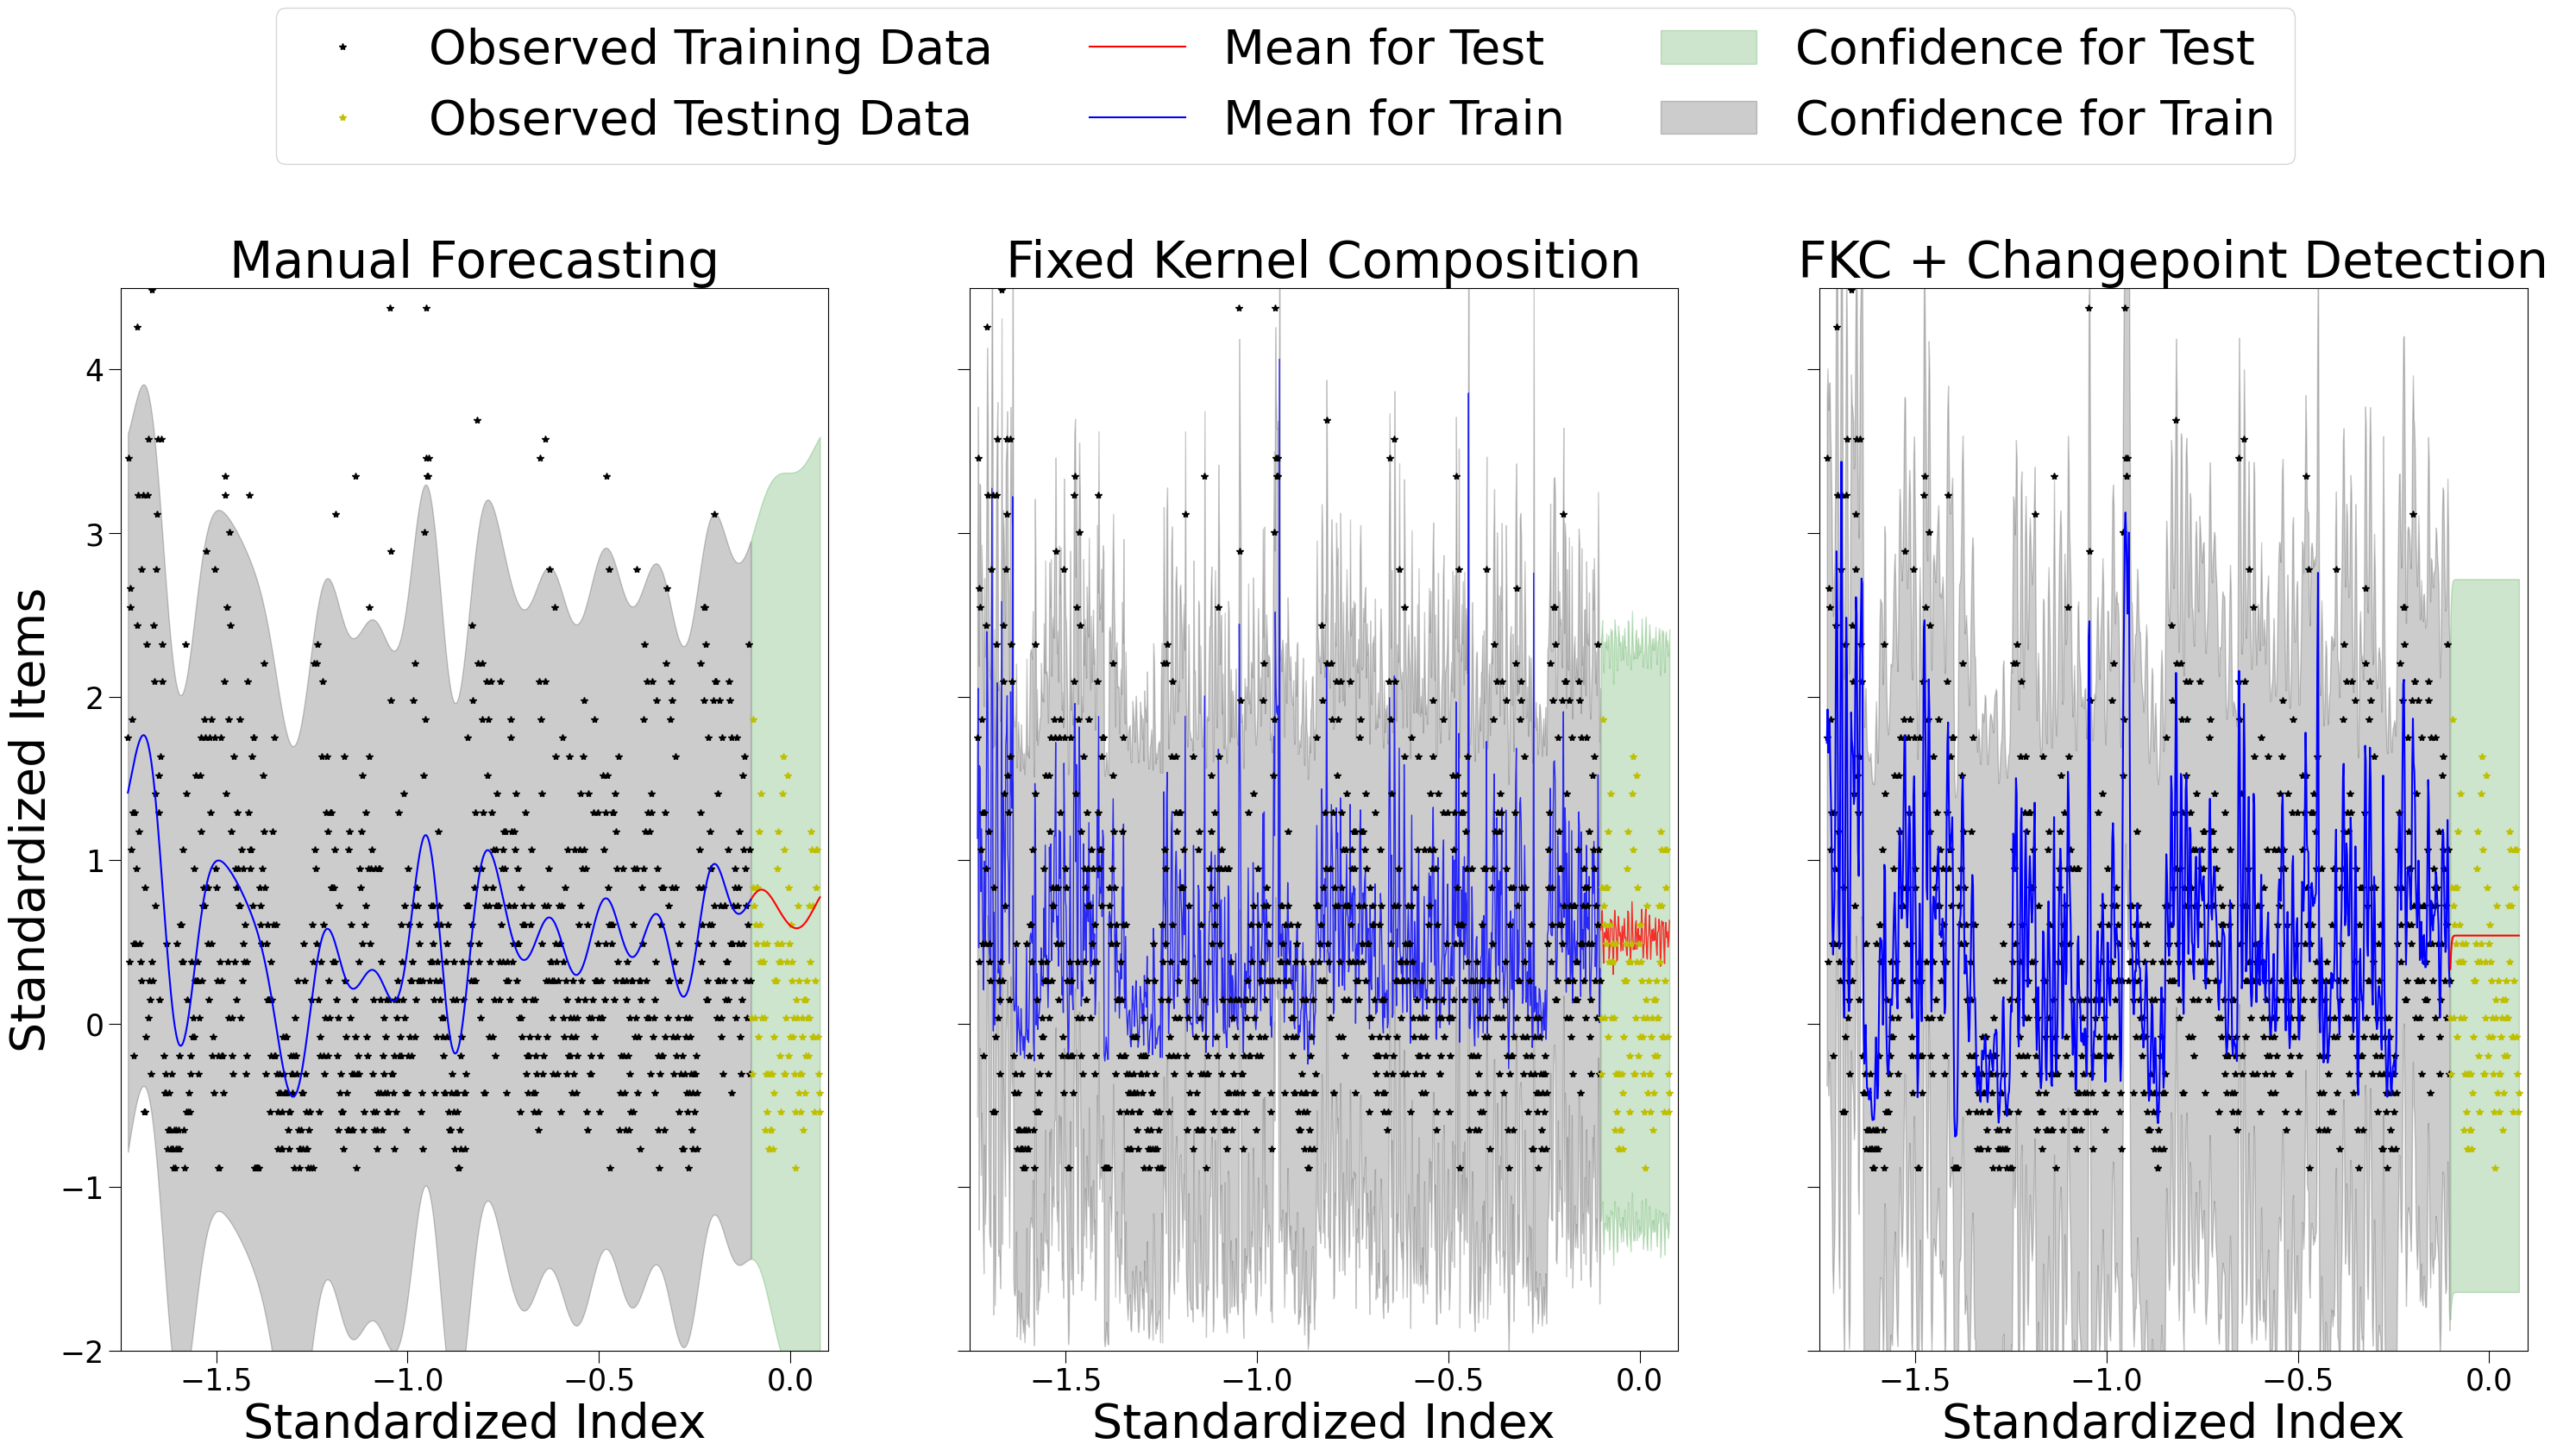

In [50]:
# Display the combined figure for the zoomed out figures. - Put in by Siddharth C.
for ax in axs:
    ax.tick_params(axis='both', which='both', labelsize=25, length = 10)
    
fig.legend(['Observed Training Data', 'Observed Testing Data', 'Mean for Test', 'Mean for Train', 'Confidence for Test', 'Confidence for Train'], fontsize=40, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3)
display(fig)
# Change to 0.95 instead of 1.05 for vertical.

In [51]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
!pip install torch
import torch
!pip install gpytorch
import gpytorch
import random

%matplotlib inline
%load_ext autoreload
%autoreload 2
torch.manual_seed(123)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
df = pd.read_csv('sales_train_edited.csv')
df

ParserError: Error tokenizing data. C error: Expected 3 fields in line 1914, saw 5


In [ ]:
#Plotting data with time
plt.rcParams['figure.figsize'] = 12, 8
sns.lineplot(x='id', y='FOODS_1_032_CA_1_validation', data=df)
plt.xlabel('month')
plt.ylabel('value')
plt.ylim([0, 32])

In [ ]:
#Plotting data with time
plt.rcParams['figure.figsize'] = 12, 8
df.plot.scatter(x='id', y='FOODS_1_032_CA_1_validation')
plt.xlabel('month')
plt.ylabel('value')
plt.xlim([0, 1000])
plt.ylim([0, 80])

In [ ]:
#Plotting auto-correlation
from statsmodels.graphics.tsaplots import plot_acf

acf = plot_acf(df['id'])

In [ ]:
#converting dataframe to tensors
targets_df = pd.DataFrame(data=(df['id']))
targets_df.columns = ['targets']
torch_tensor = torch.tensor(targets_df['targets'].values)
train_x = torch_tensor


targets_df = pd.DataFrame(data=(df['FOODS_1_032_CA_1_validation']))
targets_df.columns = ['targets']
torch_tensor2 = torch.tensor(targets_df['targets'].values)
train_y = torch_tensor2.float()
# See why train_x and train_y are being made from the same column/row of the dataset. They should be different?
#split test set
test_x = train_x[900:1000]
train_x = train_x[1:900]
test_y = train_y[900:1000]
train_y = train_y[1:900]

In [ ]:
train_x = train_x.float()
test_x = test_x.float()
train_y = train_y.float()
test_y = test_y.float()

In [ ]:
#normalizing data
train_y = (train_y - train_y.mean()) / train_y.std()
test_y = (test_y - test_y.mean()) / test_y.std()
train_x = (train_x - train_x.mean()) / train_x.std()
test_x = (test_x - test_x.mean()) / test_x.std()

In [ ]:
print(len(test_x))
print(len(train_x))
print(len(test_y))
print(len(train_y))

In [ ]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale = 2.0) * gpytorch.kernels.PeriodicKernel(lengthscale = 1.5) * gpytorch.kernels.MaternKernel(nu=2.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
print(likelihood)
print(model)
print(type(likelihood))
print(type(model))

In [ ]:
model.covar_module.base_kernel[1]

In [ ]:
#training
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 80 #number of iterations


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood.float(), model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    
    # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    #     i + 1, training_iter, loss.item(),
    #     model.covar_module.base_kernel.lengthscale.item(),
    #     model.likelihood.noise.item()
    # ))
    
    print('Iter %d/%d - Loss: %.3f' % (
         i + 1, training_iter, loss.item(),
    ))
    optimizer.step()

In [ ]:
#Make predictions with the model
f_preds = model(train_x)
y_preds = likelihood(model(train_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

In [ ]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

In [ ]:
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Making predictions
    test_x = torch.linspace(0, 1, 100)
    observed_pred = likelihood(model(train_x))
    observed_pred_test = likelihood(model(test_x))
    
    # Initializing the plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    
    # Plotting training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    
    # Plotting predictive means as blue line
    ax.plot(train_x.numpy(), observed_pred.mean.numpy(), 'b')
    
    # Shade between the lower and upper confidence bounds
    ax.fill_between(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    
    ax.set_xlabel('Standardized Index')
    ax.set_ylabel('Standardized Price')
    ax.set_title('Comparison Between Index and Price (Standardized)')
    
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.show()

In [ ]:
#Evaluation
!pip install git+https://github.com/jpchen/autoforecasting.git
from sts.data import get_mvn_stats
from torch.distributions import ComposeTransform, ExpTransform

In [ ]:
#Mean Absolute Error (MAE)
pred_train = likelihood(model(train_x))
pred_test = likelihood(model(test_x))

from sts.metrics import MAE

MAE_train = MAE(train_y, pred_train.mean).item()
MAE_test = MAE(test_y, pred_test.mean).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

In [ ]:
#Continuous ranked probability score (CRPS)
!wget https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
from metrics import crps_gaussian
all_data = torch.cat([train_x, test_x], dim=0)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_all = likelihood(model(all_data))
    
train_var = pred_all.variance[:len(train_x)] 
test_var = pred_all.variance[:len(test_x)] 

# To work for the crps test.
pred_train = pred_train.mean.detach().numpy()
pred_test = pred_test.mean.detach().numpy()

crps_train = crps_gaussian(train_y, pred_train.mean(), train_var.sqrt())
crps_test = crps_gaussian(test_y, pred_test.mean(), test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

In [ ]:
#Log-likelihood (LL)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_train = likelihood(model(train_y))
    pred_test = likelihood(model(test_y))

y_preds_train_mean = pred_train.mean
y_preds_test_mean = pred_test.mean

from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(y_preds_train_mean, train_y, train_var).item()
ll_test = log_likelihood_error(y_preds_test_mean, test_y, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')

In [ ]:
scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_measure = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_measure

In [ ]:
#Autoforecasting
!pip install git+https://github.com/jpchen/autoforecasting.git

from sts.gp.model import ExactGPAdditiveModel 
from gpytorch.kernels import LinearKernel, RBFKernel

In [ ]:
from sts.data import df_to_tensor
df_float = df.astype('float32') # All issues with data fixed here, but the categories are still present (not a tensor).
df1 = df_to_tensor(df_float, normalize_cols=True) # Now a tensor

In [ ]:
from sts.data import DataTensor
# For training data
train_x = df1[:900, ['id']]
train_y = df1[:900, ['FOODS_1_032_CA_1_validation']]

test_x = df1[900:, ['id']]
test_y = df1[900:, ['FOODS_1_032_CA_1_validation']]

In [ ]:
train_x.tensor = train_x.tensor.squeeze(-1)
train_y.tensor = train_y.tensor.squeeze(-1)
test_x.tensor = test_x.tensor.squeeze(-1)
test_y.tensor = test_y.tensor.squeeze(-1)

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = ExactGPAdditiveModel(train_x, train_y, likelihood) # This model requires two DataTensors, unlike the other model. 
# model.cov.add_seasonality(
#             time_axis="index", period_length=365.25, fix_period=True
#         )

model.cov.add_trend(
    time_axis="id", kernel_cls=LinearKernel, name="LinearTrend"
)
model.cov.add_trend(
    time_axis="id",
    kernel_cls=RBFKernel,
    lengthscale=0.2,
    fix_lengthscale=True,
    name="RBFTrend",
)
model.cov.add_spectral_mixture(
    time_axis="id",
    num_mixtures=2,
    train_x=train_x.tensor,
    train_y=train_y.tensor,
    name="SM1",
)
model.cov.add_spectral_mixture(
    time_axis="id",
    num_mixtures=2,
    train_x=train_x.tensor,
    train_y=train_y.tensor,
    name="SM2",
)
model.cov.add_seasonality(
    time_axis="id", 
    period_length=0.2, 
    fix_period=True, 
    name="Seasonality"
)

In [ ]:
#Training loop
learning_rate = 0.01
num_epochs = 20 # Adjust as needed. Keep it lower until finalized.
# 1000 is a reasonable amount, as this model is quite slow at training.

trainer = model.train_init(torch.optim.Adam(model.trainable_params, lr=learning_rate))

def train():
    for epoch in range(num_epochs):
        loss = trainer(train_x, train_y)
        print(f'epoch {epoch+1}/{num_epochs}, loss {loss}')

%time train()

In [ ]:
#Predictions
#Calculate GP predictions and statistics
train_mean, train_var, train_ci = get_mvn_stats(model.predict(train_x))
test_mean, test_var, test_ci = get_mvn_stats(model.predict(test_x))

# Create a figure and axis for the plot
f, ax = plt.subplots(1, 1, figsize=(12, 5))

# Plot the training and test mean values
ax.plot(train_x.tensor, train_mean, alpha=0.8, color='blue', linewidth=1, label='train') 
ax.plot(test_x.tensor, test_mean, alpha=0.8, color='green', linewidth=1, label='test') # This one is not graphing, only the above one.

#df_4_float['index'][1853:]
# Plot the actual data points
ax.plot(train_x.tensor, train_y.tensor, 'o', markersize=1, color='black', label='actual')

# Fill the area between confidence intervals
ci_values = torch.cat([train_ci[0], test_ci[0]]), torch.cat([train_ci[1], test_ci[1]])
x = torch.cat([train_x, test_x])
ax.fill_between(x, ci_values[0], ci_values[1], alpha=0.2, label='ci', color='gray')

# Add labels, title, and legend
ax.set_xlabel('Standardized Index')
ax.set_ylabel('Standardized Price')
ax.set_title('Comparison Between Index and Price (Standardized)')
ax.legend()
# ax.legend(['1', '2', '3'])


# Show the plot
plt.show()

# Fix this issue: ValueError: 'x' is not 1-dimensional (need to re-run the x-train data twice to get the graph)
# All blocks below this one works. Please see block 26 for understanding an issue with getting the graph for this block (block 32).

In [ ]:
#Evaluation
train_mean, train_var, train_ci = get_mvn_stats(model.predict(train_x))
test_mean, test_var, test_ci = get_mvn_stats(model.predict(test_x))

# Needed to make sure the data works with the below test code that I had already modified to work with the manual kernel-fitting part.
train_x = train_x.tensor
train_y = train_y.tensor
test_x = test_x.tensor
test_y = test_y.tensor
pred_train = train_mean
pred_test = test_mean

In [ ]:
from sts.metrics import MAE
# train_mean, train_var, train_ci = get_mvn_stats(model.predict(x_train))
# test_mean, test_var, test_ci = get_mvn_stats(model.predict(x_test))
# For the above two lines, the error lies in the .predict() function, which does not seem to exist anymore. 

MAE_train = MAE(train_y, pred_train).item()
MAE_test = MAE(test_y, pred_test).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

In [ ]:
!wget https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
from metrics import crps_gaussian
crps_train = crps_gaussian(train_y, pred_train, train_var.sqrt())
crps_test = crps_gaussian(test_y, pred_test, test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

In [ ]:
from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(train_mean, pred_train, train_var).item()
ll_test = log_likelihood_error(test_mean, pred_test, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')

In [ ]:
scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_measure = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_measure

In [ ]:
#Changepoint
from sts.changepoints import BinSegChangepoint
binseg = BinSegChangepoint()
changepoints = binseg.get_changepoints(train_x, train_y) #x_train and y_train should be tensors for this line.
# create kernel
from sts.gp.cov import ChangePoint
from sts.gp.cov import Trend

# Reformatting training and testing data.
train_data = df1[:900]
test_data = df1[900:]

#RBF Kernels
rbf_kernel1 = Trend(train_data, "id", kernel=RBFKernel, lengthscale=1.0, fix_lengthscale=True)
rbf_kernel2 = Trend(train_data, "id", kernel=RBFKernel, lengthscale=1.0, fix_lengthscale=True)
rbf_kernel3 = Trend(train_data, "id", kernel=RBFKernel, lengthscale=1.0, fix_lengthscale=True)

# Creating a list of the RBF kernels to use for the changepoint
rbf_kernels = [rbf_kernel1, rbf_kernel2, rbf_kernel3]

# ChangePoint Kernel
cp_kernel = ChangePoint(
                    train_data,
                    "id",
                    rbf_kernels,
                    changepoint_location=changepoints,
                    changepoint_steep=1.0,
                    fix_changepoint_location=True,
                    fix_changepoint_steep=True,
                    name="Changepoint - RBF",
                )

model.cov.append(cp_kernel) # Adding to your model.

In [ ]:
print(model)

In [ ]:
import os
smoke_test = ("CI" in os.environ)
training_iter = 5

# Finding the optimal parameters for the model
model = ExactGPModel(train_x, train_y, likelihood)
model.train()
likelihood.train()

# Using the ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1) # Change the learning rate as needed. Lower should be better.

# Finding the marginal log likelihood, or the "loss" for GPs
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def training():
    for i in range(training_iter):
      optimizer.zero_grad()
      output = model(train_x)
      loss = -mll(output, train_y)
      loss.backward()
      print("Iter %d/%d - Loss: %.3f" % (i + 1, training_iter, loss.item()))
      optimizer.step()
        
%time training()

In [ ]:
# Get into evaluation mode, or the predictive posterior mode
# Add the training and test metrics. Ex. MSE and MAE and CRPS. Test each individually.
# These tests have been incorporated as functions into the GPModel Class

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Making predictions
    
    pred_train = likelihood(model(train_x))
    pred_test = likelihood(model(test_x))
    
    # Setting up the train_mean and test_mean so they can be used for some of the later tests.
    train_mean = pred_train.mean.numpy()
    test_mean = pred_test.mean.numpy()

    
    # Concatenate x_train and x_test together to get all data points for aid in calculating the variances.
    all_data = torch.cat([train_x, test_x], dim=0)

    # Get predictions and variances for all data points
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_all = likelihood(model(all_data))

    # Extract the variances for test and train data
    train_var = pred_all.variance[:len(train_x)]  # Variances for training data
    test_var = pred_all.variance[len(train_x):]   # Variances for test data


    # Initializing the plot
    f, ax = plt.subplots(1, 1, figsize=(12, 9))

    # Getting the upper and lower confidence bounds
    lower, upper = pred_train.confidence_region()
    lower_2, upper_2 = pred_test.confidence_region()
    
    # Plotting training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), test_y.numpy(), 'y*')

    
    # Plotting predictive means as blue line
    ax.plot(test_x.numpy(), pred_test.mean.numpy(), 'r') # For test
    ax.plot(train_x.numpy(), pred_train.mean.numpy(), 'b') # For train
    
    import matplotlib.patches as patches

    # Shading the region between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower_2.numpy(), upper_2.numpy(), alpha = 0.2, color='green')
    ax.fill_between(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, color='black')


    
    # plt.fit()
    ax.legend(['Observed Training Data', 'Obeserved Testing Data', 'Mean for Test', 'Mean for Train', 'Confidence for Test', 'Confidence for Train', 'Confidence for Test'])
    plt.show()

In [ ]:
#Evaluation
from sts.metrics import MAE
MAE_train = MAE(train_y, pred_train.mean).item()
MAE_test = MAE(test_y, pred_test.mean).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

In [ ]:
!wget https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
from metrics import crps_gaussian
pred_train, pred_test = pred_train.mean.numpy(), pred_test.mean.numpy() # To work for the crps test.
crps_train = crps_gaussian(train_y, pred_train, train_var.sqrt())
crps_test = crps_gaussian(test_y, pred_test, test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

In [ ]:
from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(train_mean, pred_train, train_var).item()
ll_test = log_likelihood_error(test_mean, pred_test, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')

In [ ]:
scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_measure = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_measure

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
!pip install torch
import torch
!pip install gpytorch
import gpytorch
import random

%matplotlib inline
%load_ext autoreload
%autoreload 2
torch.manual_seed(123)

In [ ]:
df = pd.read_csv('sales_train_edited2.csv')
df

In [ ]:
#Plotting data with time
plt.rcParams['figure.figsize'] = 12, 8
sns.lineplot(x='id', y='FOODS_1_032_CA_1_validation', data=df)
plt.xlabel('month')
plt.ylabel('value')
plt.ylim([0, 32])

In [ ]:
#Plotting data with time
plt.rcParams['figure.figsize'] = 12, 8
df.plot.scatter(x='id', y='FOODS_1_032_CA_1_validation')
plt.xlabel('month')
plt.ylabel('value')
plt.xlim([0, 1000])
plt.ylim([0, 80])

In [ ]:
#Plotting auto-correlation
from statsmodels.graphics.tsaplots import plot_acf

acf = plot_acf(df['id'])

In [ ]:
#converting dataframe to tensors
targets_df = pd.DataFrame(data=(df['id']))
targets_df.columns = ['targets']
torch_tensor = torch.tensor(targets_df['targets'].values)
train_x = torch_tensor


targets_df = pd.DataFrame(data=(df['FOODS_1_032_CA_1_validation']))
targets_df.columns = ['targets']
torch_tensor2 = torch.tensor(targets_df['targets'].values)
train_y = torch_tensor2.float()
# See why train_x and train_y are being made from the same column/row of the dataset. They should be different?
#split test set
test_x = train_x[900:1000]
train_x = train_x[1:900]
test_y = train_y[900:1000]
train_y = train_y[1:900]

In [ ]:
train_x = train_x.float()
test_x = test_x.float()
train_y = train_y.float()
test_y = test_y.float()

In [ ]:
#normalizing data
train_y = (train_y - train_y.mean()) / train_y.std()
test_y = (test_y - test_y.mean()) / test_y.std()
train_x = (train_x - train_x.mean()) / train_x.std()
test_x = (test_x - test_x.mean()) / test_x.std()

In [ ]:
print(len(test_x))
print(len(train_x))
print(len(test_y))
print(len(train_y))

In [ ]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale = 2.0) * gpytorch.kernels.PeriodicKernel(lengthscale = 1.5) * gpytorch.kernels.MaternKernel(nu=2.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
print(likelihood)
print(model)
print(type(likelihood))
print(type(model))

In [ ]:
model.covar_module.base_kernel[1]

In [ ]:
#training
import os
smoke_test = ('CI' in os.environ)
training_iter = 1000 if smoke_test else 80 #number of iterations


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood.float(), model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    
    # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    #     i + 1, training_iter, loss.item(),
    #     model.covar_module.base_kernel.lengthscale.item(),
    #     model.likelihood.noise.item()
    # ))
    
    print('Iter %d/%d - Loss: %.3f' % (
         i + 1, training_iter, loss.item(),
    ))
    optimizer.step()

In [ ]:
#Make predictions with the model
f_preds = model(train_x)
y_preds = likelihood(model(train_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

In [ ]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

In [ ]:
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Making predictions
    test_x = torch.linspace(0, 1, 100)
    observed_pred = likelihood(model(train_x))
    observed_pred_test = likelihood(model(test_x))
    
    # Initializing the plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    
    # Plotting training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    
    # Plotting predictive means as blue line
    ax.plot(train_x.numpy(), observed_pred.mean.numpy(), 'b')
    
    # Shade between the lower and upper confidence bounds
    ax.fill_between(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)

    
    ax.set_xlabel('Standardized Index')
    ax.set_ylabel('Standardized Value')
    ax.set_title('Comparison Between Index and Value (Standardized)')
    
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.show()

In [ ]:
model.eval()
likelihood.eval()
# Concatenate x_train and x_test together. 
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Making predictions
    
    pred_train = likelihood(model(train_x))
    pred_test = likelihood(model(test_x))
    
    # Setting up the train_mean and test_mean so they can be used for some of the later tests.
    train_mean = pred_train.mean.numpy()
    test_mean = pred_test.mean.numpy()

    
    # Concatenate x_train and x_test together to get all data points for aid in calculating the variances.
    all_data = torch.cat([train_x, test_x], dim=0)

    # Get predictions and variances for all data points
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_all = likelihood(model(all_data))

    # Extract the variances for test and train data
    train_var = pred_all.variance[:len(train_x)]  # Variances for training data
    test_var = pred_all.variance[len(train_x):]   # Variances for test data


    # Initializing the plot
    f, ax = plt.subplots(1, 1, figsize=(12, 9))

    # Getting the upper and lower confidence bounds
    lower, upper = pred_train.confidence_region()
    lower_2, upper_2 = pred_test.confidence_region()
    
    # Plotting training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), test_y.numpy(), 'y*')

    
    # Plotting predictive means as blue line
    ax.plot(test_x.numpy(), pred_test.mean.numpy(), 'r') # For test
    ax.plot(train_x.numpy(), pred_train.mean.numpy(), 'b') # For train
    
    import matplotlib.patches as patches

    # Shading the region between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower_2.numpy(), upper_2.numpy(), alpha = 0.2, color='green')
    ax.fill_between(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, color='black')

    
    # plt.fit()
    ax.legend(['Observed Training Data', 'Obeserved Testing Data', 'Mean for Test', 'Mean for Train', 'Confidence for Test', 'Confidence for Train', 'Confidence for Test'])
    plt.show()

In [ ]:
#Evaluation
!pip install git+https://github.com/jpchen/autoforecasting.git
from sts.data import get_mvn_stats
from torch.distributions import ComposeTransform, ExpTransform

In [ ]:
#Mean Absolute Error (MAE)
pred_train = likelihood(model(train_x))
pred_test = likelihood(model(test_x))

from sts.metrics import MAE

MAE_train = MAE(train_y, pred_train.mean).item()
MAE_test = MAE(test_y, pred_test.mean).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

In [ ]:
#Continuous ranked probability score (CRPS)
!wget https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
from metrics import crps_gaussian
all_data = torch.cat([train_x, test_x], dim=0)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_all = likelihood(model(all_data))
    
train_var = pred_all.variance[:len(train_x)] 
test_var = pred_all.variance[:len(test_x)] 

# To work for the crps test.
pred_train = pred_train.mean.detach().numpy()
pred_test = pred_test.mean.detach().numpy()

crps_train = crps_gaussian(train_y, pred_train.mean(), train_var.sqrt())
crps_test = crps_gaussian(test_y, pred_test.mean(), test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

In [ ]:
#Log-likelihood (LL)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_train = likelihood(model(train_y))
    pred_test = likelihood(model(test_y))

y_preds_train_mean = pred_train.mean
y_preds_test_mean = pred_test.mean

from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(y_preds_train_mean, train_y, train_var).item()
ll_test = log_likelihood_error(y_preds_test_mean, test_y, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')

In [ ]:
scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_measure = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_measure

In [ ]:
#Autoforecasting
!pip install git+https://github.com/jpchen/autoforecasting.git

from sts.gp.model import ExactGPAdditiveModel 
from gpytorch.kernels import LinearKernel, RBFKernel

In [ ]:
from sts.data import df_to_tensor
df_float = df.astype('float32') # All issues with data fixed here, but the categories are still present (not a tensor).
df1 = df_to_tensor(df_float, normalize_cols=True) # Now a tensor

In [ ]:
from sts.data import DataTensor
# For training data
train_x = df1[:900, ['id']]
train_y = df1[:900, ['FOODS_1_032_CA_1_validation']]

test_x = df1[900:, ['id']]
test_y = df1[900:, ['FOODS_1_032_CA_1_validation']]

In [ ]:
train_x.tensor = train_x.tensor.squeeze(-1)
train_y.tensor = train_y.tensor.squeeze(-1)
test_x.tensor = test_x.tensor.squeeze(-1)
test_y.tensor = test_y.tensor.squeeze(-1)

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = ExactGPAdditiveModel(train_x, train_y, likelihood) # This model requires two DataTensors, unlike the other model. 
# model.cov.add_seasonality(
#             time_axis="index", period_length=365.25, fix_period=True
#         )

model.cov.add_trend(
    time_axis="id", kernel_cls=LinearKernel, name="LinearTrend"
)
model.cov.add_trend(
    time_axis="id",
    kernel_cls=RBFKernel,
    lengthscale=0.2,
    fix_lengthscale=True,
    name="RBFTrend",
)
model.cov.add_spectral_mixture(
    time_axis="id",
    num_mixtures=2,
    train_x=train_x.tensor,
    train_y=train_y.tensor,
    name="SM1",
)
model.cov.add_spectral_mixture(
    time_axis="id",
    num_mixtures=2,
    train_x=train_x.tensor,
    train_y=train_y.tensor,
    name="SM2",
)
model.cov.add_seasonality(
    time_axis="id", 
    period_length=0.2, 
    fix_period=True, 
    name="Seasonality"
)

In [ ]:
#Training loop
learning_rate = 0.01
num_epochs = 80 # Adjust as needed. Keep it lower until finalized.
# 1000 is a reasonable amount, as this model is quite slow at training.

trainer = model.train_init(torch.optim.Adam(model.trainable_params, lr=learning_rate))

def train():
    for epoch in range(num_epochs):
        loss = trainer(train_x, train_y)
        print(f'epoch {epoch+1}/{num_epochs}, loss {loss}')

%time train()

In [ ]:
#Predictions
#Calculate GP predictions and statistics
train_mean, train_var, train_ci = get_mvn_stats(model.predict(train_x))
test_mean, test_var, test_ci = get_mvn_stats(model.predict(test_x))

# Create a figure and axis for the plot
f, ax = plt.subplots(1, 1, figsize=(12, 5))

# Plot the training and test mean values
ax.plot(train_x.tensor, train_mean, alpha=0.8, color='blue', linewidth=1, label='train') 
ax.plot(test_x.tensor, test_mean, alpha=0.8, color='green', linewidth=1, label='test') # This one is not graphing, only the above one.

#df_4_float['index'][1853:]
# Plot the actual data points
ax.plot(train_x.tensor, train_y.tensor, 'o', markersize=1, color='black', label='actual')

# Fill the area between confidence intervals
ci_values = torch.cat([train_ci[0], test_ci[0]]), torch.cat([train_ci[1], test_ci[1]])
x = torch.cat([train_x, test_x])
ax.fill_between(x, ci_values[0], ci_values[1], alpha=0.2, label='ci', color='gray')

# Add labels, title, and legend
ax.set_xlabel('Standardized Index')
ax.set_ylabel('Standardized Price')
ax.set_title('Comparison Between Index and Price (Standardized)')
ax.legend()
# ax.legend(['1', '2', '3'])


# Show the plot
plt.show()

# Fix this issue: ValueError: 'x' is not 1-dimensional (need to re-run the x-train data twice to get the graph)
# All blocks below this one works. Please see block 26 for understanding an issue with getting the graph for this block (block 32).

In [ ]:
#Evaluation
train_mean, train_var, train_ci = get_mvn_stats(model.predict(train_x))
test_mean, test_var, test_ci = get_mvn_stats(model.predict(test_x))

# Needed to make sure the data works with the below test code that I had already modified to work with the manual kernel-fitting part.
train_x = train_x.tensor
train_y = train_y.tensor
test_x = test_x.tensor
test_y = test_y.tensor
pred_train = train_mean
pred_test = test_mean

In [ ]:
from sts.metrics import MAE
# train_mean, train_var, train_ci = get_mvn_stats(model.predict(x_train))
# test_mean, test_var, test_ci = get_mvn_stats(model.predict(x_test))
# For the above two lines, the error lies in the .predict() function, which does not seem to exist anymore. 

MAE_train = MAE(train_y, pred_train).item()
MAE_test = MAE(test_y, pred_test).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

In [ ]:
!wget https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
from metrics import crps_gaussian
crps_train = crps_gaussian(train_y, pred_train, train_var.sqrt())
crps_test = crps_gaussian(test_y, pred_test, test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

In [ ]:
from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(train_mean, pred_train, train_var).item()
ll_test = log_likelihood_error(test_mean, pred_test, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')

In [ ]:
scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_measure = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_measure

In [ ]:
#Changepoint
from sts.changepoints import BinSegChangepoint
binseg = BinSegChangepoint()
changepoints = binseg.get_changepoints(train_x, train_y) #x_train and y_train should be tensors for this line.
# create kernel
from sts.gp.cov import ChangePoint
from sts.gp.cov import Trend

# Reformatting training and testing data.
train_data = df1[:900]
test_data = df1[900:]

#RBF Kernels
rbf_kernel1 = Trend(train_data, "id", kernel=RBFKernel, lengthscale=1.0, fix_lengthscale=True)
rbf_kernel2 = Trend(train_data, "id", kernel=RBFKernel, lengthscale=1.0, fix_lengthscale=True)
rbf_kernel3 = Trend(train_data, "id", kernel=RBFKernel, lengthscale=1.0, fix_lengthscale=True)

# Creating a list of the RBF kernels to use for the changepoint
rbf_kernels = [rbf_kernel1, rbf_kernel2, rbf_kernel3]

# ChangePoint Kernel
cp_kernel = ChangePoint(
                    train_data,
                    "id",
                    rbf_kernels,
                    changepoint_location=changepoints,
                    changepoint_steep=1.0,
                    fix_changepoint_location=True,
                    fix_changepoint_steep=True,
                    name="Changepoint - RBF",
                )

model.cov.append(cp_kernel) # Adding to your model.

In [ ]:
print(model)

In [ ]:
import os
smoke_test = ("CI" in os.environ)
training_iter = 80

# Finding the optimal parameters for the model
model = ExactGPModel(train_x, train_y, likelihood)
model.train()
likelihood.train()

# Using the ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1) # Change the learning rate as needed. Lower should be better.

# Finding the marginal log likelihood, or the "loss" for GPs
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def training():
    for i in range(training_iter):
      optimizer.zero_grad()
      output = model(train_x)
      loss = -mll(output, train_y)
      loss.backward()
      print("Iter %d/%d - Loss: %.3f" % (i + 1, training_iter, loss.item()))
      optimizer.step()
        
%time training()

In [ ]:
# Get into evaluation mode, or the predictive posterior mode
# Add the training and test metrics. Ex. MSE and MAE and CRPS. Test each individually.
# These tests have been incorporated as functions into the GPModel Class

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Making predictions
    
    pred_train = likelihood(model(train_x))
    pred_test = likelihood(model(test_x))
    
    # Setting up the train_mean and test_mean so they can be used for some of the later tests.
    train_mean = pred_train.mean.numpy()
    test_mean = pred_test.mean.numpy()

    
    # Concatenate x_train and x_test together to get all data points for aid in calculating the variances.
    all_data = torch.cat([train_x, test_x], dim=0)

    # Get predictions and variances for all data points
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_all = likelihood(model(all_data))

    # Extract the variances for test and train data
    train_var = pred_all.variance[:len(train_x)]  # Variances for training data
    test_var = pred_all.variance[len(train_x):]   # Variances for test data


    # Initializing the plot
    f, ax = plt.subplots(1, 1, figsize=(12, 9))

    # Getting the upper and lower confidence bounds
    lower, upper = pred_train.confidence_region()
    lower_2, upper_2 = pred_test.confidence_region()
    
    # Plotting training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), test_y.numpy(), 'y*')

    
    # Plotting predictive means as blue line
    ax.plot(test_x.numpy(), pred_test.mean.numpy(), 'r') # For test
    ax.plot(train_x.numpy(), pred_train.mean.numpy(), 'b') # For train
    
    import matplotlib.patches as patches

    # Shading the region between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower_2.numpy(), upper_2.numpy(), alpha = 0.2, color='green')
    ax.fill_between(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, color='black')


    
    # plt.fit()
    ax.legend(['Observed Training Data', 'Obeserved Testing Data', 'Mean for Test', 'Mean for Train', 'Confidence for Test', 'Confidence for Train', 'Confidence for Test'])
    plt.show()

In [ ]:
#Evaluation
from sts.metrics import MAE
MAE_train = MAE(train_y, pred_train.mean).item()
MAE_test = MAE(test_y, pred_test.mean).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

In [ ]:
!wget https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
from metrics import crps_gaussian
pred_train, pred_test = pred_train.mean.numpy(), pred_test.mean.numpy() # To work for the crps test.
crps_train = crps_gaussian(train_y, pred_train, train_var.sqrt())
crps_test = crps_gaussian(test_y, pred_test, test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

In [ ]:
from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(train_mean, pred_train, train_var).item()
ll_test = log_likelihood_error(test_mean, pred_test, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')

In [ ]:
scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_measure = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_measure

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
!pip install torch
import torch
!pip install gpytorch
import gpytorch
import random

%matplotlib inline
%load_ext autoreload
%autoreload 2
torch.manual_seed(123)

In [ ]:
df = pd.read_csv('sales_train_edited.csv')
df

In [ ]:
#Plotting data with time
plt.rcParams['figure.figsize'] = 12, 8
sns.lineplot(x='id', y='FOODS_1_032_CA_1_validation', data=df)
plt.xlabel('month')
plt.ylabel('value')
plt.ylim([0, 32])

In [ ]:
#Plotting data with time
plt.rcParams['figure.figsize'] = 12, 8
df.plot.scatter(x='id', y='FOODS_1_032_CA_1_validation')
plt.xlabel('month')
plt.ylabel('value')
plt.xlim([0, 1000])
plt.ylim([0, 80])

In [ ]:
#Plotting auto-correlation
from statsmodels.graphics.tsaplots import plot_acf

acf = plot_acf(df['id'])

In [ ]:
#converting dataframe to tensors
targets_df = pd.DataFrame(data=(df['id']))
targets_df.columns = ['targets']
torch_tensor = torch.tensor(targets_df['targets'].values)
train_x = torch_tensor


targets_df = pd.DataFrame(data=(df['FOODS_1_032_CA_1_validation']))
targets_df.columns = ['targets']
torch_tensor2 = torch.tensor(targets_df['targets'].values)
train_y = torch_tensor2.float()
# See why train_x and train_y are being made from the same column/row of the dataset. They should be different?
#split test set
test_x = train_x[900:1000]
train_x = train_x[1:900]
test_y = train_y[900:1000]
train_y = train_y[1:900]

In [ ]:
train_x = train_x.float()
test_x = test_x.float()
train_y = train_y.float()
test_y = test_y.float()

In [ ]:
#normalizing data
train_y = (train_y - train_y.mean()) / train_y.std()
test_y = (test_y - test_y.mean()) / test_y.std()
train_x = (train_x - train_x.mean()) / train_x.std()
test_x = (test_x - test_x.mean()) / test_x.std()

In [ ]:
print(len(test_x))
print(len(train_x))
print(len(test_y))
print(len(train_y))

In [ ]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale = 2.0) * gpytorch.kernels.PeriodicKernel(lengthscale = 1.5) * gpytorch.kernels.MaternKernel(nu=2.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
print(likelihood)
print(model)
print(type(likelihood))
print(type(model))

In [ ]:
model.covar_module.base_kernel[1]

In [ ]:
#training
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 80 #number of iterations


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood.float(), model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    
    # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    #     i + 1, training_iter, loss.item(),
    #     model.covar_module.base_kernel.lengthscale.item(),
    #     model.likelihood.noise.item()
    # ))
    
    print('Iter %d/%d - Loss: %.3f' % (
         i + 1, training_iter, loss.item(),
    ))
    optimizer.step()

In [ ]:
#Make predictions with the model
f_preds = model(train_x)
y_preds = likelihood(model(train_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

In [ ]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

In [ ]:
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Making predictions
    test_x = torch.linspace(0, 1, 100)
    observed_pred = likelihood(model(train_x))
    observed_pred_test = likelihood(model(test_x))
    
    # Initializing the plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    
    # Plotting training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    
    # Plotting predictive means as blue line
    ax.plot(train_x.numpy(), observed_pred.mean.numpy(), 'b')
    
    # Shade between the lower and upper confidence bounds
    ax.fill_between(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    
    ax.set_xlabel('Standardized Index')
    ax.set_ylabel('Standardized Price')
    ax.set_title('Comparison Between Index and Price (Standardized)')
    
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.show()

In [ ]:
#Evaluation
!pip install git+https://github.com/jpchen/autoforecasting.git
from sts.data import get_mvn_stats
from torch.distributions import ComposeTransform, ExpTransform

In [ ]:
#Mean Absolute Error (MAE)
pred_train = likelihood(model(train_x))
pred_test = likelihood(model(test_x))

from sts.metrics import MAE

MAE_train = MAE(train_y, pred_train.mean).item()
MAE_test = MAE(test_y, pred_test.mean).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

In [ ]:
#Continuous ranked probability score (CRPS)
!wget https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
from metrics import crps_gaussian
all_data = torch.cat([train_x, test_x], dim=0)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_all = likelihood(model(all_data))
    
train_var = pred_all.variance[:len(train_x)] 
test_var = pred_all.variance[:len(test_x)] 

# To work for the crps test.
pred_train = pred_train.mean.detach().numpy()
pred_test = pred_test.mean.detach().numpy()

crps_train = crps_gaussian(train_y, pred_train.mean(), train_var.sqrt())
crps_test = crps_gaussian(test_y, pred_test.mean(), test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

In [ ]:
#Log-likelihood (LL)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_train = likelihood(model(train_y))
    pred_test = likelihood(model(test_y))

y_preds_train_mean = pred_train.mean
y_preds_test_mean = pred_test.mean

from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(y_preds_train_mean, train_y, train_var).item()
ll_test = log_likelihood_error(y_preds_test_mean, test_y, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')

In [ ]:
scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_measure = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_measure

In [ ]:
#Autoforecasting
!pip install git+https://github.com/jpchen/autoforecasting.git

from sts.gp.model import ExactGPAdditiveModel 
from gpytorch.kernels import LinearKernel, RBFKernel

In [ ]:
from sts.data import df_to_tensor
df_float = df.astype('float32') # All issues with data fixed here, but the categories are still present (not a tensor).
df1 = df_to_tensor(df_float, normalize_cols=True) # Now a tensor

In [ ]:
from sts.data import DataTensor
# For training data
train_x = df1[:900, ['id']]
train_y = df1[:900, ['FOODS_1_032_CA_1_validation']]

test_x = df1[900:, ['id']]
test_y = df1[900:, ['FOODS_1_032_CA_1_validation']]

In [ ]:
train_x.tensor = train_x.tensor.squeeze(-1)
train_y.tensor = train_y.tensor.squeeze(-1)
test_x.tensor = test_x.tensor.squeeze(-1)
test_y.tensor = test_y.tensor.squeeze(-1)

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = ExactGPAdditiveModel(train_x, train_y, likelihood) # This model requires two DataTensors, unlike the other model. 
# model.cov.add_seasonality(
#             time_axis="index", period_length=365.25, fix_period=True
#         )

model.cov.add_trend(
    time_axis="id", kernel_cls=LinearKernel, name="LinearTrend"
)
model.cov.add_trend(
    time_axis="id",
    kernel_cls=RBFKernel,
    lengthscale=0.2,
    fix_lengthscale=True,
    name="RBFTrend",
)
model.cov.add_spectral_mixture(
    time_axis="id",
    num_mixtures=2,
    train_x=train_x.tensor,
    train_y=train_y.tensor,
    name="SM1",
)
model.cov.add_spectral_mixture(
    time_axis="id",
    num_mixtures=2,
    train_x=train_x.tensor,
    train_y=train_y.tensor,
    name="SM2",
)
model.cov.add_seasonality(
    time_axis="id", 
    period_length=0.2, 
    fix_period=True, 
    name="Seasonality"
)

In [ ]:
#Training loop
learning_rate = 0.01
num_epochs = 20 # Adjust as needed. Keep it lower until finalized.
# 1000 is a reasonable amount, as this model is quite slow at training.

trainer = model.train_init(torch.optim.Adam(model.trainable_params, lr=learning_rate))

def train():
    for epoch in range(num_epochs):
        loss = trainer(train_x, train_y)
        print(f'epoch {epoch+1}/{num_epochs}, loss {loss}')

%time train()

In [ ]:
#Predictions
#Calculate GP predictions and statistics
train_mean, train_var, train_ci = get_mvn_stats(model.predict(train_x))
test_mean, test_var, test_ci = get_mvn_stats(model.predict(test_x))

# Create a figure and axis for the plot
f, ax = plt.subplots(1, 1, figsize=(12, 5))

# Plot the training and test mean values
ax.plot(train_x.tensor, train_mean, alpha=0.8, color='blue', linewidth=1, label='train') 
ax.plot(test_x.tensor, test_mean, alpha=0.8, color='green', linewidth=1, label='test') # This one is not graphing, only the above one.

#df_4_float['index'][1853:]
# Plot the actual data points
ax.plot(train_x.tensor, train_y.tensor, 'o', markersize=1, color='black', label='actual')

# Fill the area between confidence intervals
ci_values = torch.cat([train_ci[0], test_ci[0]]), torch.cat([train_ci[1], test_ci[1]])
x = torch.cat([train_x, test_x])
ax.fill_between(x, ci_values[0], ci_values[1], alpha=0.2, label='ci', color='gray')

# Add labels, title, and legend
ax.set_xlabel('Standardized Index')
ax.set_ylabel('Standardized Price')
ax.set_title('Comparison Between Index and Price (Standardized)')
ax.legend()
# ax.legend(['1', '2', '3'])


# Show the plot
plt.show()

# Fix this issue: ValueError: 'x' is not 1-dimensional (need to re-run the x-train data twice to get the graph)
# All blocks below this one works. Please see block 26 for understanding an issue with getting the graph for this block (block 32).

In [ ]:
#Evaluation
train_mean, train_var, train_ci = get_mvn_stats(model.predict(train_x))
test_mean, test_var, test_ci = get_mvn_stats(model.predict(test_x))

# Needed to make sure the data works with the below test code that I had already modified to work with the manual kernel-fitting part.
train_x = train_x.tensor
train_y = train_y.tensor
test_x = test_x.tensor
test_y = test_y.tensor
pred_train = train_mean
pred_test = test_mean

In [ ]:
from sts.metrics import MAE
# train_mean, train_var, train_ci = get_mvn_stats(model.predict(x_train))
# test_mean, test_var, test_ci = get_mvn_stats(model.predict(x_test))
# For the above two lines, the error lies in the .predict() function, which does not seem to exist anymore. 

MAE_train = MAE(train_y, pred_train).item()
MAE_test = MAE(test_y, pred_test).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

In [ ]:
!wget https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
from metrics import crps_gaussian
crps_train = crps_gaussian(train_y, pred_train, train_var.sqrt())
crps_test = crps_gaussian(test_y, pred_test, test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

In [ ]:
from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(train_mean, pred_train, train_var).item()
ll_test = log_likelihood_error(test_mean, pred_test, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')

In [ ]:
scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_measure = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_measure

In [ ]:
#Changepoint
from sts.changepoints import BinSegChangepoint
binseg = BinSegChangepoint()
changepoints = binseg.get_changepoints(train_x, train_y) #x_train and y_train should be tensors for this line.
# create kernel
from sts.gp.cov import ChangePoint
from sts.gp.cov import Trend

# Reformatting training and testing data.
train_data = df1[:900]
test_data = df1[900:]

#RBF Kernels
rbf_kernel1 = Trend(train_data, "id", kernel=RBFKernel, lengthscale=1.0, fix_lengthscale=True)
rbf_kernel2 = Trend(train_data, "id", kernel=RBFKernel, lengthscale=1.0, fix_lengthscale=True)
rbf_kernel3 = Trend(train_data, "id", kernel=RBFKernel, lengthscale=1.0, fix_lengthscale=True)

# Creating a list of the RBF kernels to use for the changepoint
rbf_kernels = [rbf_kernel1, rbf_kernel2, rbf_kernel3]

# ChangePoint Kernel
cp_kernel = ChangePoint(
                    train_data,
                    "id",
                    rbf_kernels,
                    changepoint_location=changepoints,
                    changepoint_steep=1.0,
                    fix_changepoint_location=True,
                    fix_changepoint_steep=True,
                    name="Changepoint - RBF",
                )

model.cov.append(cp_kernel) # Adding to your model.

In [ ]:
print(model)

In [ ]:
import os
smoke_test = ("CI" in os.environ)
training_iter = 5

# Finding the optimal parameters for the model
model = ExactGPModel(train_x, train_y, likelihood)
model.train()
likelihood.train()

# Using the ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1) # Change the learning rate as needed. Lower should be better.

# Finding the marginal log likelihood, or the "loss" for GPs
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def training():
    for i in range(training_iter):
      optimizer.zero_grad()
      output = model(train_x)
      loss = -mll(output, train_y)
      loss.backward()
      print("Iter %d/%d - Loss: %.3f" % (i + 1, training_iter, loss.item()))
      optimizer.step()
        
%time training()

In [ ]:
# Get into evaluation mode, or the predictive posterior mode
# Add the training and test metrics. Ex. MSE and MAE and CRPS. Test each individually.
# These tests have been incorporated as functions into the GPModel Class

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Making predictions
    
    pred_train = likelihood(model(train_x))
    pred_test = likelihood(model(test_x))
    
    # Setting up the train_mean and test_mean so they can be used for some of the later tests.
    train_mean = pred_train.mean.numpy()
    test_mean = pred_test.mean.numpy()

    
    # Concatenate x_train and x_test together to get all data points for aid in calculating the variances.
    all_data = torch.cat([train_x, test_x], dim=0)

    # Get predictions and variances for all data points
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_all = likelihood(model(all_data))

    # Extract the variances for test and train data
    train_var = pred_all.variance[:len(train_x)]  # Variances for training data
    test_var = pred_all.variance[len(train_x):]   # Variances for test data


    # Initializing the plot
    f, ax = plt.subplots(1, 1, figsize=(12, 9))

    # Getting the upper and lower confidence bounds
    lower, upper = pred_train.confidence_region()
    lower_2, upper_2 = pred_test.confidence_region()
    
    # Plotting training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), test_y.numpy(), 'y*')

    
    # Plotting predictive means as blue line
    ax.plot(test_x.numpy(), pred_test.mean.numpy(), 'r') # For test
    ax.plot(train_x.numpy(), pred_train.mean.numpy(), 'b') # For train
    
    import matplotlib.patches as patches

    # Shading the region between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower_2.numpy(), upper_2.numpy(), alpha = 0.2, color='green')
    ax.fill_between(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, color='black')


    
    # plt.fit()
    ax.legend(['Observed Training Data', 'Obeserved Testing Data', 'Mean for Test', 'Mean for Train', 'Confidence for Test', 'Confidence for Train', 'Confidence for Test'])
    plt.show()

In [ ]:
#Evaluation
from sts.metrics import MAE
MAE_train = MAE(train_y, pred_train.mean).item()
MAE_test = MAE(test_y, pred_test.mean).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

In [ ]:
!wget https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
from metrics import crps_gaussian
pred_train, pred_test = pred_train.mean.numpy(), pred_test.mean.numpy() # To work for the crps test.
crps_train = crps_gaussian(train_y, pred_train, train_var.sqrt())
crps_test = crps_gaussian(test_y, pred_test, test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

In [ ]:
from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(train_mean, pred_train, train_var).item()
ll_test = log_likelihood_error(test_mean, pred_test, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')

In [ ]:
scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_measure = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_measure